In [2]:
# !pip install adjustText
# !pip install kaleido

# !pip install libpysal geopandas esda mapclassify contextily splot
# import geopandas as gpd
# import pandas as pd

# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# main_path="drive/MyDrive/Maharashtra - Climate-Health"

# Data set-up
- Import df (poshan, climate, socio-economic data)
- Import shapefile (drop duplicates)
- Merge data into shapefile


In [4]:
gdf=gpd.read_file(f"{main_path}/2_Data/MH_Taluka_WCD/MH_Taluka_WCD.shp")

In [5]:
gdf["sdtcode11"]=gdf["sdtcode11"].astype(str)

In [6]:
gdf["sdtcode11"]=gdf["sdtcode11"].str[1:]

In [7]:
gdf.drop_duplicates(subset="sdtcode11", inplace=True)

In [8]:
df=pd.read_csv(f'{main_path}/2_Data/Climate-POSHAN/poshan_climate_block.csv')

In [ ]:
df["dtcode11"]=df["dtcode11"].astype(str)
df["sdtcode11"]=df["sdtcode11"].astype(str)

In [ ]:
df["Number of Heat Wave/Severe Heat Wave Days"]=df['Number of Heat Wave Days'] + df['Number of Severe Heat Wave Days']

In [ ]:
heat_vars=['Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)',
           'Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)',
          'Number of Heavy & Extremely Rainfall Days',
           'Number of Heat Wave/Severe Heat Wave Days',
       'Number of Drought Months']



- SAM, MAM k=3 - where are the hotspots?
- Mean, Max, Min, Mean Relative Humidity (2m) (%)
- Rainfall
- Mean UV Index,Maximum UV Index

In [ ]:
malnutrition_vars=[
'Stunting - Moderate (%)',
'Stunting - Severe (%)',
'Underweight - Moderate (%)',
'Underweight - Severe (%)',
'Wasting - SAM (%)',
'Wasting - MAM (%)']


In [ ]:
absolute_vars=[
'Stunting - Moderate',
'Stunting - Severe',
'Underweight - Moderate',
'Underweight - Severe',
'Wasting - SAM',
'Wasting - MAM']

In [ ]:
df_model=df[malnutrition_vars + heat_vars + absolute_vars + ["dtcode11", "dtname", "sdtcode11", "sdtname"]]

In [ ]:
df_model.rename(columns={"Number of Heavy & Extremely Rainfall Days":"Number of Heavy & Extremely Heavy Rainfall Days"}, inplace=True)

<ipython-input-106-f555c630fbce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.rename(columns={"Number of Heavy & Extremely Rainfall Days":"Number of Heavy & Extremely Heavy Rainfall Days"}, inplace=True)


In [ ]:
# 2 blocks in the shapefile do not have cases on poshan - dropped these
merged_gdf=gdf.merge(df_model,on=["dtcode11", "dtname", "sdtcode11", "sdtname"], how="left")

In [ ]:
merged_gdf[merged_gdf["Stunting - Severe"].isna()]

OBJECTID stcode11 dtcode11 sdtcode11     Shape_Leng    Shape_Area  \
81       4050       27      505      4031  321371.142796  7.219522e+08   
268      4237       27      523      4224  156768.592059  3.132600e+08   

          stname  dtname         sdtname  Subdt_LGD  ...  \
81   MAHARASHTRA  Nagpur  Nagpur (Rural)     4031.0  ...   
268  MAHARASHTRA     Bid           Parli     4224.0  ...   

     Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)  \
81                                                 NaN        
268                                                NaN        

     Number of Heavy & Extremely Heavy Rainfall Days  \
81                                               NaN   
268                                              NaN   

    Number of Heat Wave/Severe Heat Wave Days Number of Drought Months  \
81                                        NaN                      NaN   
268                                       NaN                      NaN   

     Stunting - Moderate  Stunting - Severe  Underweight - Moderate  \
81                   NaN                NaN                     NaN   
268                  NaN                NaN                     NaN   

     Underweight - Severe  Wasting - SAM  Wasting - MAM  
81                    NaN            NaN            NaN  
268                   NaN            NaN            NaN  

[2 rows x 33 columns]

In [ ]:
# Setup
output_dir = f"{main_path}/graphs/cluster_outputs"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
gdf_clean.columns

Index(['OBJECTID', 'stcode11', 'dtcode11', 'sdtcode11', 'Shape_Leng',
       'Shape_Area', 'stname', 'dtname', 'sdtname', 'Subdt_LGD', 'Dist_LGD',
       'State_LGD', 'Updated sd', 'geometry', 'Stunting - Moderate (%)',
       'Stunting - Severe (%)', 'Underweight - Moderate (%)',
       'Underweight - Severe (%)', 'Wasting - SAM (%)', 'Wasting - MAM (%)',
       'Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)',
       'Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)',
       'Number of Heavy & Extremely Heavy Rainfall Days',
       'Number of Heat Wave/Severe Heat Wave Days', 'Number of Drought Months',
       'Stunting - Moderate', 'Stunting - Severe', 'Underweight - Moderate',
       'Underweight - Severe', 'Wasting - SAM', 'Wasting - MAM',
       'Stunting - Moderate (%)_cluster_raw',
       'Stunting - Moderate (%)_cluster',
       'Stunting - Moderate (%)_cluster_label', 'color'

# 1a. K-Means Clustering based on individual malnutrition indicators (%)

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.patches import Patch
from adjustText import adjust_text

gdf_clean = merged_gdf.dropna(subset=["geometry"] + malnutrition_vars)
gdf_clean = gdf_clean.set_geometry("geometry")

for indicator in malnutrition_vars + ['Mean Daily Average Temperature (2m) (°C)'] + ['Mean Daily Maximum Temperature (2m) (°C)'] + ['Number of Heat Wave/Severe Heat Wave Days']:
    print(f"\n============================")
    print(f"🔍 KMeans Clustering for: {indicator}")
    print(f"============================")

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(gdf_clean[[indicator]])

    # KMeans
    kmeans = KMeans(n_clusters=3, random_state=42)
    gdf_clean[f"{indicator}_cluster_raw"] = kmeans.fit_predict(X_scaled)

    # Assign labels based on actual means
    means = gdf_clean.groupby(f"{indicator}_cluster_raw")[indicator].mean().sort_values(ascending=False)
    cluster_order = {old: new for new, old in enumerate(means.index)}
    label_map = {0: 'HIGH', 1: 'MODERATE', 2: 'LOW'}

    gdf_clean[f"{indicator}_cluster"] = gdf_clean[f"{indicator}_cluster_raw"].map(cluster_order)
    gdf_clean[f"{indicator}_cluster_label"] = gdf_clean[f"{indicator}_cluster"].map(label_map)

    cluster_colors = {
        'HIGH': '#FF4C4C',
        'MODERATE': '#FFA500',
        'LOW': '#3CB371'
    }

    gdf_clean["color"] = gdf_clean[f"{indicator}_cluster_label"].map(cluster_colors)

    # Cluster Summary

    if indicator=='Mean Daily Average Temperature (2m) (°C)':
      cluster_summary = gdf_clean.groupby(f"{indicator}_cluster_label").agg({
        indicator: 'mean',
        'geometry': 'count',
        'Stunting - Moderate (%)': 'mean',
        'Stunting - Severe (%)': 'mean',
        'Underweight - Moderate (%)': 'mean',
        'Underweight - Severe (%)': 'mean',
        'Wasting - SAM (%)': 'mean',
        'Wasting - MAM (%)': 'mean',



    }).rename(columns={"geometry": "Number of Blocks"}).reset_index()

    elif indicator=="Mean Daily Maximum Temperature (2m) (°C)":
      cluster_summary = gdf_clean.groupby(f"{indicator}_cluster_label").agg({
        indicator: 'mean',
        'geometry': 'count',
        'Stunting - Moderate (%)': 'mean',
        'Stunting - Severe (%)': 'mean',
        'Underweight - Moderate (%)': 'mean',
        'Underweight - Severe (%)': 'mean',
        'Wasting - SAM (%)': 'mean',
        'Wasting - MAM (%)': 'mean',



    }).rename(columns={"geometry": "Number of Blocks"}).reset_index()

    elif indicator=="Number of Heat Wave/Severe Heat Wave Days":
       cluster_summary = gdf_clean.groupby(f"{indicator}_cluster_label").agg({
        indicator: 'sum',
        'geometry': 'count',
        'Stunting - Moderate (%)': 'mean',
        'Stunting - Severe (%)': 'mean',
        'Underweight - Moderate (%)': 'mean',
        'Underweight - Severe (%)': 'mean',
        'Wasting - SAM (%)': 'mean',
        'Wasting - MAM (%)': 'mean'


    }).rename(columns={"geometry": "Number of Blocks"}).reset_index()

    else:

      cluster_summary = gdf_clean.groupby(f"{indicator}_cluster_label").agg({
          indicator: 'mean',
          'geometry': 'count',
          'Mean Daily Average Temperature (2m) (°C)': 'mean',
          'Mean Daily Maximum Temperature (2m) (°C)': 'mean',
          'Mean Daily Minimum Temperature (2m) (°C)': 'mean',
          'Number of Heat Wave/Severe Heat Wave Days': 'mean',

      }).rename(columns={"geometry": "Number of Blocks"}).reset_index()

    cluster_summary["Cluster_Color"] = cluster_summary[f"{indicator}_cluster_label"].map(cluster_colors)


    # Melt for plotting
    melted = cluster_summary.melt(id_vars=[f"{indicator}_cluster_label", "Cluster_Color"], var_name='Variable', value_name='Mean')
    melted = melted.rename(columns={f"{indicator}_cluster_label": "Cluster"})

    # Sort Cluster as categorical: HIGH > MODERATE > LOW
    cluster_order_sorted = ["HIGH", "MODERATE", "LOW"]
    melted["Cluster"] = pd.Categorical(melted["Cluster"], categories=cluster_order_sorted, ordered=True)

    # Grid layout (adjusted for slide-friendly aspect ratio)
    variables = melted['Variable'].unique()
    cluster_colors_list = [cluster_colors[c] for c in cluster_order_sorted]

    n_cols = 2
    n_rows = int(np.ceil(len(variables) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 2.5), constrained_layout=True)
    axes = axes.flatten()
    for i, var in enumerate(variables):
        ax = axes[i]
        subset = melted[melted["Variable"] == var]
        means = [subset[subset["Cluster"] == c]["Mean"].values[0] for c in cluster_order_sorted]

        x_pos = np.arange(len(cluster_order_sorted))
        bars = ax.bar(x_pos, means, color=cluster_colors_list)

        # Add labels above the bars with some space
        for idx, bar in enumerate(bars):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                    f"{bar.get_height():.2f}", ha='center', fontsize=9)

        ax.set_xticks(x_pos)
        ax.set_xticklabels(cluster_order_sorted)
        ax.set_title(var, fontsize=10, loc='center')

        # Dynamically set y-axis limit
        max_y = max(means)
        ax.set_ylim(0, max_y + 20)

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Main title
    fig.suptitle(f"Cluster Characteristics {indicator}- Mean Values", fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.savefig(f"{output_dir}/bar_vertical_matplotlib_{indicator}.png")
    plt.show()

    # ===================== Choropleth Map =====================

    gdf_clean = gdf_clean.to_crs(epsg=3857)
    gdf_labels = gdf_clean[
        (gdf_clean["sdtname"].str.lower() == "nandurbar")
    ].copy()
    gdf_labels["coords"] = gdf_labels["geometry"].centroid

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    gdf_clean.plot(color=gdf_clean["color"], edgecolor="white", linewidth=0.5, ax=ax)

    # Add non-overlapping labels
    texts = []
    for _, row in gdf_labels.iterrows():
        x, y = row["coords"].x + 10000, row["coords"].y + 5000
        text = ax.text(x, y, row["sdtname"], fontsize=8, ha="center", va="center")
        texts.append(text)

    adjust_text(
        texts, ax=ax,
        only_move={'points': 'y', 'text': 'y'},
        arrowprops=dict(arrowstyle="-", color="gray", lw=0.6, shrinkA=5, shrinkB=5),
        force_points=0.1, force_text=0.4,
        expand_text=(1.1, 1.3), expand_points=(1.1, 1.3)
    )

    legend_elements = [Patch(facecolor=clr, label=lbl) for lbl, clr in cluster_colors.items()]
    ax.legend(handles=legend_elements, title="Cluster", loc="lower left")

    ax.set_title(f"Cluster Map - {indicator.replace('_', ' ').replace('(Count)','').title()}", fontsize=14, fontweight='bold')
    ax.axis("off")
    plt.tight_layout()
    # plt.savefig(f"{output_dir}/{indicator}_relative_cluster_map.png", dpi=300)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_model.columns

Index(['Stunting - Moderate (%)', 'Stunting - Severe (%)',
       'Underweight - Moderate (%)', 'Underweight - Severe (%)',
       'Wasting - SAM (%)', 'Wasting - MAM (%)',
       'Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)',
       'Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)',
       'Number of Heavy & Extremely Heavy Rainfall Days',
       'Number of Heat Wave/Severe Heat Wave Days', 'Number of Drought Months',
       'Stunting - Moderate', 'Stunting - Severe', 'Underweight - Moderate',
       'Underweight - Severe', 'Wasting - SAM', 'Wasting - MAM', 'dtcode11',
       'dtname', 'sdtcode11', 'sdtname'],
      dtype='object')

# 1b. K-Means Clustering of blocks based on all malnutrition indicators combined

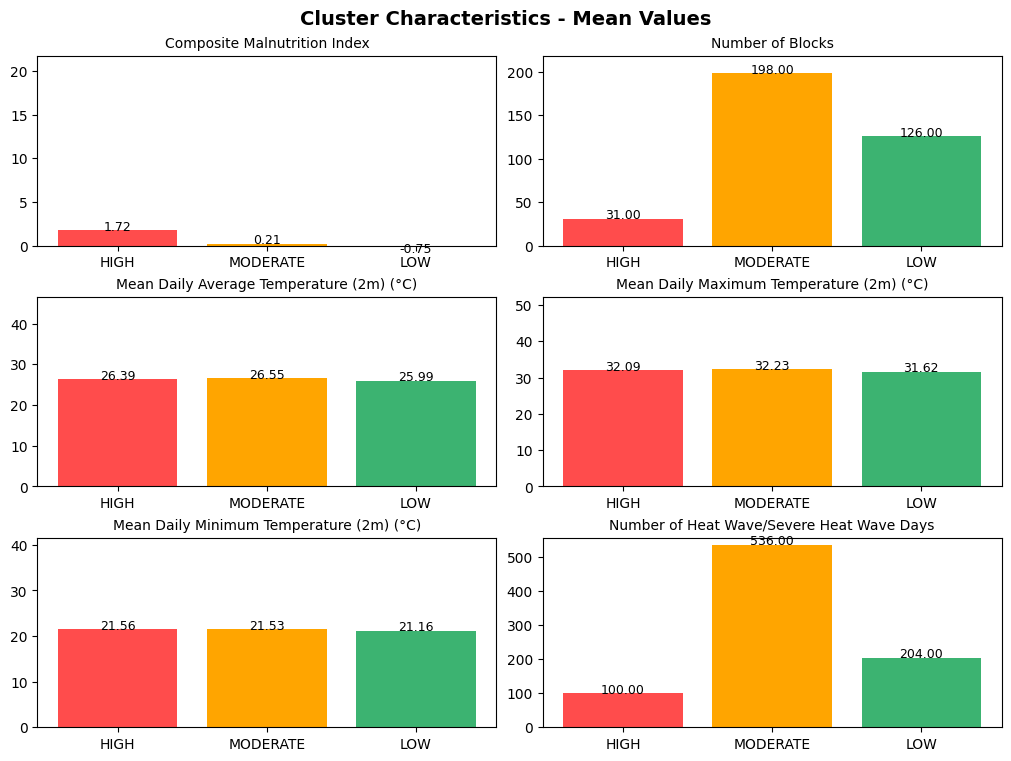

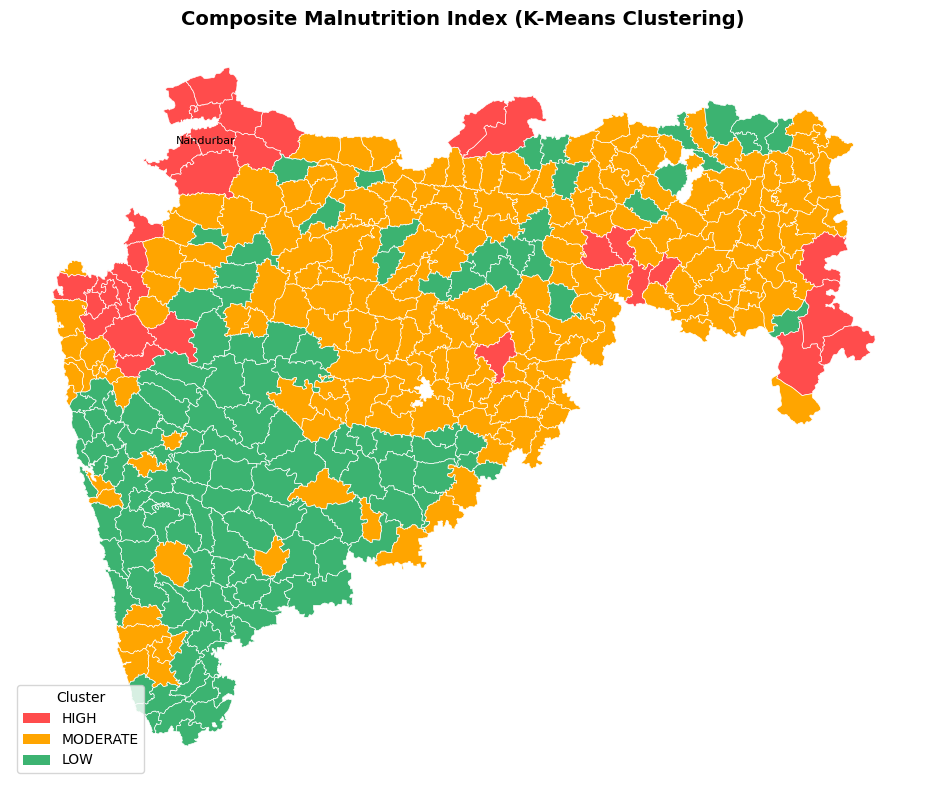

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.patches import Patch
from adjustText import adjust_text


mal_gdf_clean = merged_gdf.dropna(subset=["geometry"] + malnutrition_vars).copy()
mal_gdf_clean = mal_gdf_clean.set_geometry("geometry")

# Standardize all malnutrition features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(mal_gdf_clean[malnutrition_vars])

# Compute vulnerability index (mean z-score across all indicators)
mal_gdf_clean["Composite Malnutrition Index"] = X_scaled.mean(axis=1)

# Run KMeans clustering on vulnerability index
kmeans = KMeans(n_clusters=3, random_state=42)
mal_gdf_clean["composite_cluster_raw"] = kmeans.fit_predict(mal_gdf_clean[["Composite Malnutrition Index"]])

# Assign labels based on actual vulnerability_index means
means = mal_gdf_clean.groupby("composite_cluster_raw")["Composite Malnutrition Index"].mean().sort_values(ascending=False)
cluster_order = {old: new for new, old in enumerate(means.index)}
label_map = {0: 'HIGH', 1: 'MODERATE', 2: 'LOW'}

mal_gdf_clean["composite_cluster"] = mal_gdf_clean["composite_cluster_raw"].map(cluster_order)
mal_gdf_clean["composite_cluster_label"] = mal_gdf_clean["composite_cluster"].map(label_map)

# Assign cluster colors
cluster_colors = {
    'HIGH': '#FF4C4C',
    'MODERATE': '#FFA500',
    'LOW': '#3CB371'
}
mal_gdf_clean["color"] = mal_gdf_clean["composite_cluster_label"].map(cluster_colors)

# Cluster summary
mal_cluster_summary = mal_gdf_clean.groupby("composite_cluster_label").agg({
    "Composite Malnutrition Index": 'mean',
    'geometry': 'count',
    'Mean Daily Average Temperature (2m) (°C)': 'mean',
    'Mean Daily Maximum Temperature (2m) (°C)': 'mean',
    'Mean Daily Minimum Temperature (2m) (°C)': 'mean',
    'Number of Heat Wave/Severe Heat Wave Days': 'sum',

}).rename(columns={"geometry": "Number of Blocks"}).reset_index()

mal_cluster_summary = mal_cluster_summary.round(2)

mal_cluster_summary["Cluster_Color"] = mal_cluster_summary["composite_cluster_label"].map(cluster_colors)
mal_cluster_summary = mal_cluster_summary.rename(columns={"composite_cluster_label": "Cluster"})

# Melt for plotting
mal_cluster_melted = mal_cluster_summary.melt(id_vars=["Cluster", "Cluster_Color"], var_name='Variable', value_name='Mean')

# Sort Cluster as categorical: HIGH > MODERATE > LOW
cluster_order_sorted = ["HIGH", "MODERATE", "LOW"]
mal_cluster_melted["Cluster"] = pd.Categorical(mal_cluster_melted["Cluster"], categories=cluster_order_sorted, ordered=True)

# Grid layout (adjusted for slide-friendly aspect ratio)
variables = mal_cluster_melted['Variable'].unique()
cluster_colors_list = [cluster_colors[c] for c in cluster_order_sorted]

n_cols = 2
n_rows = int(np.ceil(len(variables) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 2.5), constrained_layout=True)
axes = axes.flatten()
for i, var in enumerate(variables):
    ax = axes[i]
    subset = mal_cluster_melted[mal_cluster_melted["Variable"] == var]
    means = [subset[subset["Cluster"] == c]["Mean"].values[0] for c in cluster_order_sorted]

    x_pos = np.arange(len(cluster_order_sorted))
    bars = ax.bar(x_pos, means, color=cluster_colors_list)

    # Add labels above the bars with some space
    for idx, bar in enumerate(bars):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                f"{bar.get_height():.2f}", ha='center', fontsize=9)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(cluster_order_sorted)
    ax.set_title(var, fontsize=10, loc='center')

    # Dynamically set y-axis limit
    max_y = max(means)
    ax.set_ylim(0, max_y + 20)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Main title
fig.suptitle("Cluster Characteristics - Mean Values", fontsize=14, fontweight='bold')
plt.savefig(f"{output_dir}/composite_bar_vertical_matplotlib.png")



# Choropleth Map
mal_gdf_clean = mal_gdf_clean.to_crs(epsg=3857)
gdf_labels = mal_gdf_clean[
    (mal_gdf_clean["sdtname"].str.lower() == "nandurbar")
].copy()
gdf_labels["coords"] = gdf_labels["geometry"].centroid

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

mal_gdf_clean.plot(color=mal_gdf_clean["color"], edgecolor="white", linewidth=0.5, ax=ax)

# Add non-overlapping labels
texts = []
for _, row in gdf_labels.iterrows():
    x, y = row["coords"].x + 10000, row["coords"].y + 5000
    text = ax.text(x, y, row["sdtname"], fontsize=8, ha="center", va="center")
    texts.append(text)

adjust_text(
    texts, ax=ax,
    only_move={'points': 'y', 'text': 'y'},
    arrowprops=dict(arrowstyle="-", color="gray", lw=0.6, shrinkA=5, shrinkB=5),
    force_points=0.1, force_text=0.4,
    expand_text=(1.1, 1.3), expand_points=(1.1, 1.3)
)

legend_elements = [Patch(facecolor=clr, label=lbl) for lbl, clr in cluster_colors.items()]
ax.legend(handles=legend_elements, title="Cluster", loc="lower left")

ax.set_title("Composite Malnutrition Index (K-Means Clustering)", fontsize=14, fontweight="bold")
ax.axis("off")
plt.tight_layout()
# plt.savefig(f"{output_dir}/composite_cluster_map.png", dpi=300)
plt.show()

In [ ]:
df_model.columns

Index(['Stunting - Moderate (%)', 'Stunting - Severe (%)',
       'Underweight - Moderate (%)', 'Underweight - Severe (%)',
       'Wasting - SAM (%)', 'Wasting - MAM (%)',
       'Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)',
       'Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)',
       'Number of Heavy & Extremely Heavy Rainfall Days',
       'Number of Heat Wave/Severe Heat Wave Days', 'Number of Drought Months',
       'Stunting - Moderate', 'Stunting - Severe', 'Underweight - Moderate',
       'Underweight - Severe', 'Wasting - SAM', 'Wasting - MAM', 'dtcode11',
       'dtname', 'sdtcode11', 'sdtname'],
      dtype='object')

# 1d. K-Means Clustering based on composite temperature index



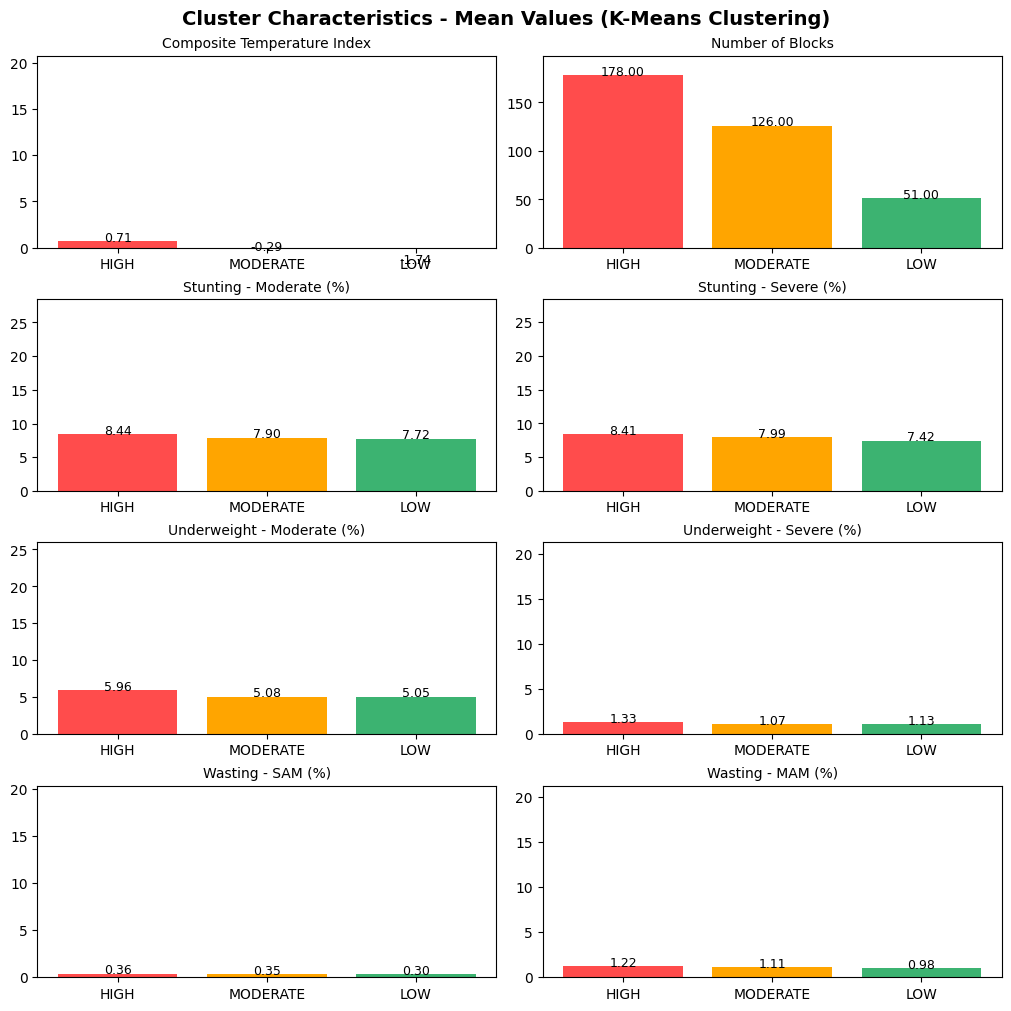

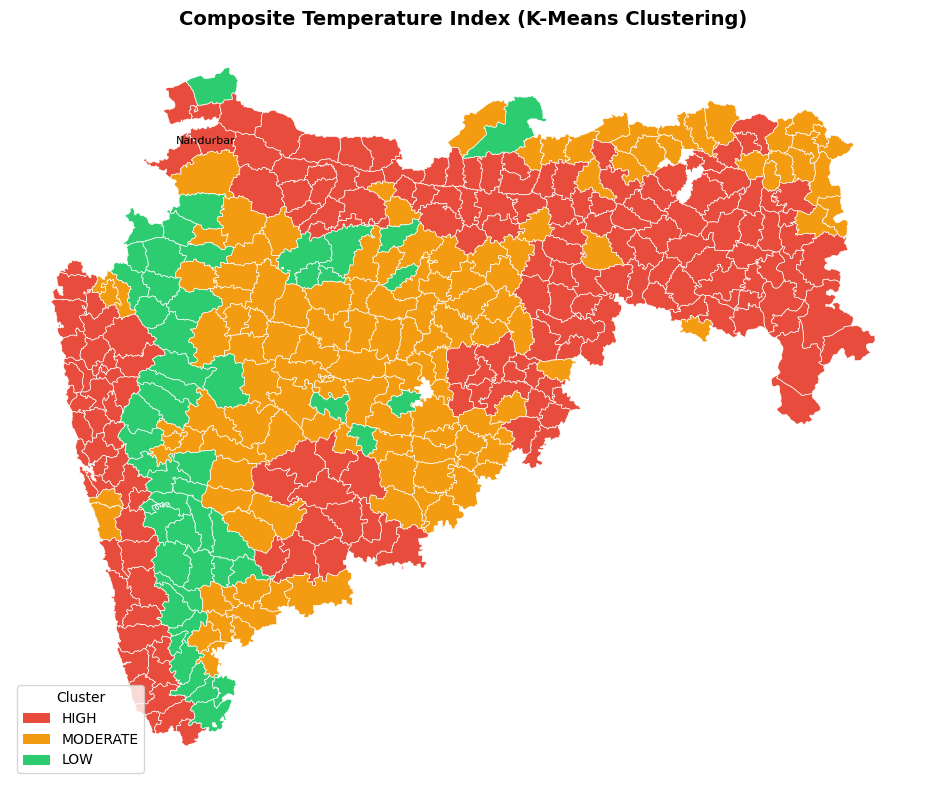

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.patches import Patch
from adjustText import adjust_text

selected_heat_vars=['Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)']

# Setup
output_dir = f"{main_path}/graphs/cluster_outputs"
os.makedirs(output_dir, exist_ok=True)

# Clean and prepare geodataframe
climate_gdf_clean = merged_gdf.dropna(subset=["geometry"] + selected_heat_vars).copy()
climate_gdf_clean = climate_gdf_clean.set_geometry("geometry")

# Standardize all malnutrition + climate features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(climate_gdf_clean[selected_heat_vars])

# Compute Climate Vulnerability Index
climate_gdf_clean["Composite Temperature Index"] = X_scaled.mean(axis=1)

# Run KMeans clustering on vulnerability index
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
climate_gdf_clean["climate_composite_cluster_raw"] = kmeans.fit_predict(climate_gdf_clean[["Composite Temperature Index"]])

# Assign labels based on actual vulnerability index means
means = climate_gdf_clean.groupby("climate_composite_cluster_raw")["Composite Temperature Index"].mean().sort_values(ascending=False)
cluster_order = {old: new for new, old in enumerate(means.index)}

# Label map and color scheme
climate_label_map = {0: "HIGH", 1: "MODERATE", 2: "LOW"}
climate_cluster_colors = {
    'HIGH': '#E74C3C',
    'MODERATE': '#F39C12',
    'LOW': '#2ECC71'
}

# Relabel clusters
climate_gdf_clean["climate_composite_cluster"] = climate_gdf_clean["climate_composite_cluster_raw"].map(cluster_order)
climate_gdf_clean["climate_composite_cluster_label"] = climate_gdf_clean["climate_composite_cluster"].map(climate_label_map)
climate_gdf_clean["color"] = climate_gdf_clean["climate_composite_cluster_label"].map(climate_cluster_colors)

# Cluster summary
climate_cluster_summary = climate_gdf_clean.groupby("climate_composite_cluster_label").agg({
    "Composite Temperature Index": 'mean',
    'geometry': 'count',
     'Stunting - Moderate (%)': 'mean',
        'Stunting - Severe (%)': 'mean',
        'Underweight - Moderate (%)': 'mean',
        'Underweight - Severe (%)': 'mean',
        'Wasting - SAM (%)': 'mean',
        'Wasting - MAM (%)': 'mean',
}).rename(columns={"geometry": "Number of Blocks"}).reset_index()

climate_cluster_summary["Cluster_Color"] = climate_cluster_summary["climate_composite_cluster_label"].map(climate_cluster_colors)
climate_cluster_summary = climate_cluster_summary.rename(columns={"climate_composite_cluster_label": "Cluster"})

# Melt for plotting
climate_melted = climate_cluster_summary.melt(id_vars=['Cluster', 'Cluster_Color'], var_name='Variable', value_name='Mean')

# Sort cluster labels
cluster_order_sorted = ["HIGH", "MODERATE", "LOW"]
climate_melted["Cluster"] = pd.Categorical(climate_melted["Cluster"], categories=cluster_order_sorted, ordered=True)

# Grid layout (adjusted for slide-friendly aspect ratio)
variables = climate_melted['Variable'].unique()
cluster_colors_list = [cluster_colors[c] for c in cluster_order_sorted]

n_cols = 2
n_rows = int(np.ceil(len(variables) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 2.5), constrained_layout=True)
axes = axes.flatten()
for i, var in enumerate(variables):
    ax = axes[i]
    subset = climate_melted[climate_melted["Variable"] == var]
    means = [subset[subset["Cluster"] == c]["Mean"].values[0] for c in cluster_order_sorted]

    x_pos = np.arange(len(cluster_order_sorted))
    bars = ax.bar(x_pos, means, color=cluster_colors_list)

    # Add labels above the bars with some space
    for idx, bar in enumerate(bars):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                f"{bar.get_height():.2f}", ha='center', fontsize=9)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(cluster_order_sorted)
    ax.set_title(var, fontsize=10, loc='center')

    # Dynamically set y-axis limit
    max_y = max(means)
    ax.set_ylim(0, max_y + 20)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Main title
fig.suptitle("Cluster Characteristics - Mean Values (K-Means Clustering)", fontsize=14, fontweight='bold')
# plt.savefig(f"{output_dir}/heat_bar_vertical_matplotlib.png")

# Choropleth Map
climate_gdf_clean = climate_gdf_clean.to_crs(epsg=3857)
gdf_labels = climate_gdf_clean[
    (climate_gdf_clean["sdtname"].str.lower() == "nandurbar")
].copy()

gdf_labels = gdf_labels.copy()
gdf_labels["coords"] = gdf_labels.geometry.centroid

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
climate_gdf_clean.plot(color=climate_gdf_clean["color"], edgecolor="white", linewidth=0.5, ax=ax)

# Add non-overlapping labels
texts = []
for _, row in gdf_labels.iterrows():
    x, y = row["coords"].x + 10000, row["coords"].y + 5000
    text = ax.text(x, y, row["sdtname"], fontsize=8, ha="center", va="center")
    texts.append(text)

adjust_text(
    texts, ax=ax,
    only_move={'points': 'y', 'text': 'y'},
    arrowprops=dict(arrowstyle="-", color="gray", lw=0.6, shrinkA=5, shrinkB=5),
    force_points=0.1, force_text=0.4,
    expand_text=(1.1, 1.3), expand_points=(1.1, 1.3)
)

legend_elements = [Patch(facecolor=clr, label=lbl) for lbl, clr in climate_cluster_colors.items()]
ax.legend(handles=legend_elements, title="Cluster", loc="lower left")

ax.set_title("Composite Temperature Index (K-Means Clustering)", fontsize=14, fontweight="bold")
ax.axis("off")
plt.tight_layout()
# plt.savefig(f"{output_dir}/heat_cluster_map.png", dpi=300)
plt.show()

In [ ]:
merged_blocks=climate_gdf_clean[["sdtcode11", "sdtname", "geometry", "climate_composite_cluster_label", "color"]].merge(mal_gdf_clean[["sdtcode11", "composite_cluster_label"]], on="sdtcode11")

In [ ]:
merged_blocks.loc[(merged_blocks["climate_composite_cluster_label"]=="HIGH") & (merged_blocks["composite_cluster_label"]=="HIGH"), "new_color"]="#E74C3C"

In [ ]:
merged_blocks["new_color"]=merged_blocks["new_color"].fillna('#FFFFFF')

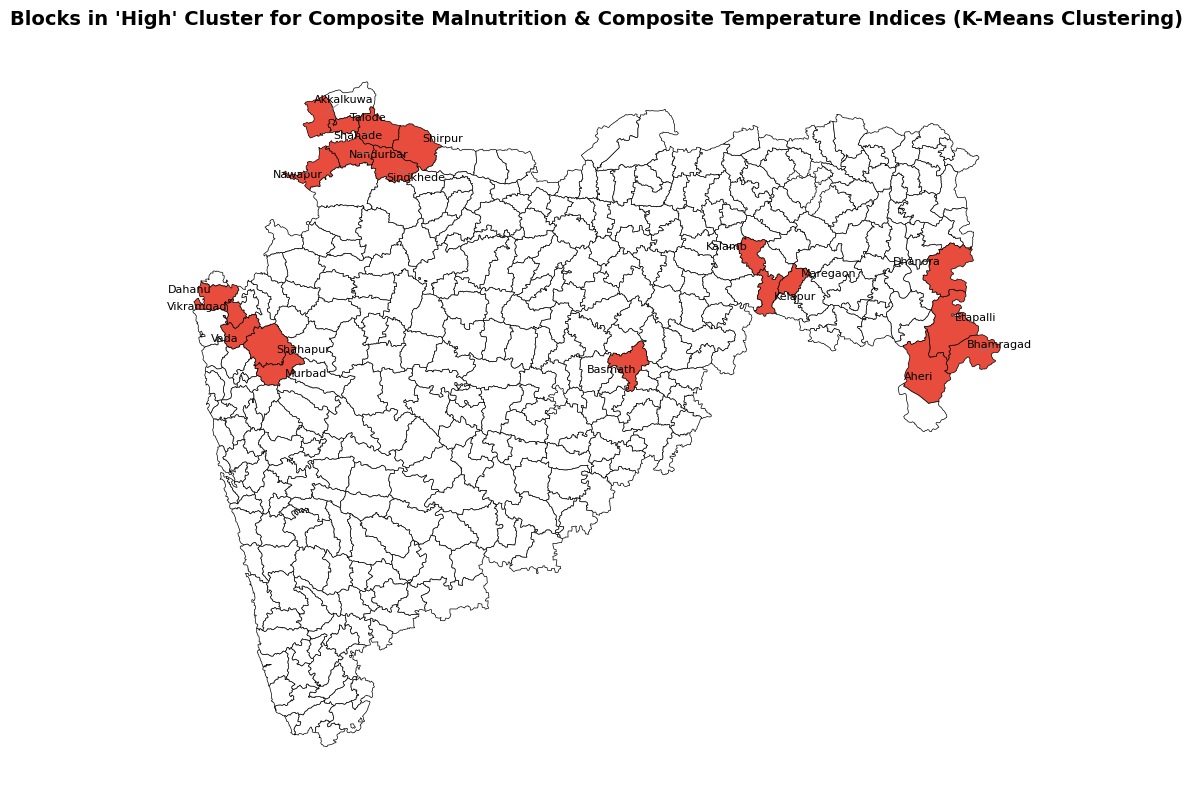

In [ ]:
# Choropleth Map
merged_blocks = merged_blocks.to_crs(epsg=3857)
gdf_labels = merged_blocks[
    (merged_blocks["climate_composite_cluster_label"].str.lower() == "high") & (merged_blocks["composite_cluster_label"].str.lower() == "high")
].copy()

gdf_labels = gdf_labels.copy()
gdf_labels["coords"] = gdf_labels.geometry.centroid

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged_blocks.plot(color=merged_blocks["new_color"], edgecolor="black", linewidth=0.5, ax=ax)

# Add non-overlapping labels
texts = []
for _, row in gdf_labels.iterrows():
    x, y = row["coords"].x, row["coords"].y
    text = ax.text(x, y, row["sdtname"], fontsize=8, ha="center", va="center")
    texts.append(text)

adjust_text(
    texts, ax=ax,
    only_move={'points': 'y', 'text': 'y'},
    arrowprops=dict(arrowstyle="-", color="gray", lw=0.6, shrinkA=5, shrinkB=5),
    force_points=0.1, force_text=0.4,
    expand_text=(1.1, 1.3), expand_points=(1.1, 1.3)
)

# legend_elements = [Patch(facecolor=clr, label=lbl) for lbl, clr in climate_cluster_colors.items()]
# ax.legend(handles=legend_elements, title="Cluster", loc="lower left")

ax.set_title("Blocks in 'High' Cluster for Composite Malnutrition & Composite Temperature Indices (K-Means Clustering)", fontsize=14, fontweight="bold")
ax.axis("off")
plt.tight_layout()
# plt.savefig(f"{output_dir}/high_heat_malnutrition.png", dpi=300)
plt.show()

In [ ]:
merged_blocks.loc[(merged_blocks["climate_composite_cluster_label"]=="HIGH") & (merged_blocks["composite_cluster_label"]=="HIGH")]

sdtcode11    sdtname                                           geometry  \
0        3950  Akkalkuwa  POLYGON ((8251226.966 2473354.665, 8250381.533...   
2        3952     Talode  POLYGON ((8276551.413 2475110.471, 8275520.669...   
3        3953    Shahade  POLYGON ((8293498.165 2485311.13, 8294870.822 ...   
4        3954  Nandurbar  POLYGON ((8292827.396 2442709.906, 8293365.893...   
5        3955    Nawapur  POLYGON ((8240231.022 2441768.272, 8239545.176...   
6        3956    Shirpur  POLYGON ((8350240.141 2414212.547, 8348844.402...   
7        3957  Sindkhede  POLYGON ((8314002.703 2440092.237, 8315038.998...   
105      4056    Dhanora  POLYGON ((8963388.372 2329930.818, 8964820.319...   
109      4060   Etapalli  POLYGON ((8966446.894 2275147.053, 8965959.45 ...   
110      4061  Bhamragad  POLYGON ((9000468.584 2197892.859, 8999765.66 ...   
111      4062      Aheri  POLYGON ((8922290.656 2231969.413, 8922801.164...   
130      4081     Kalamb  POLYGON ((8740514.164 2333611.254, 8738921.514...   
139      4090    Kelapur  POLYGON ((8738094.368 2303238.641, 8738426.047...   
141      4092   Maregaon  POLYGON ((8771828.619 2308634.23, 8772548.151 ...   
164      4115    Basmath  POLYGON ((8599725.33 2219123.013, 8599498.607 ...   
208      4167   Shahapur  POLYGON ((8180317.854 2240475.791, 8182103.99 ...   
212      4171     Murbad  POLYGON ((8202509.59 2207405.178, 8203404.389 ...   
347      4158     Dahanu  POLYGON ((8127895.654 2284431.713, 8128777.997...   
348      4159  Vikramgad  POLYGON ((8142434.944 2262235.163, 8141251.616...   
351      4162       Vada  POLYGON ((8164234.351 2236893.321, 8162889.178...   

    climate_composite_cluster_label    color composite_cluster_label new_color  
0                              HIGH  #E74C3C                    HIGH   #E74C3C  
2                              HIGH  #E74C3C                    HIGH   #E74C3C  
3                              HIGH  #E74C3C                    HIGH   #E74C3C  
4                              HIGH  #E74C3C                    HIGH   #E74C3C  
5                              HIGH  #E74C3C                    HIGH   #E74C3C  
6                              HIGH  #E74C3C                    HIGH   #E74C3C  
7                              HIGH  #E74C3C                    HIGH   #E74C3C  
105                            HIGH  #E74C3C                    HIGH   #E74C3C  
109                            HIGH  #E74C3C                    HIGH   #E74C3C  
110                            HIGH  #E74C3C                    HIGH   #E74C3C  
111                            HIGH  #E74C3C                    HIGH   #E74C3C  
130                            HIGH  #E74C3C                    HIGH   #E74C3C  
139                            HIGH  #E74C3C                    HIGH   #E74C3C  
141                            HIGH  #E74C3C                    HIGH   #E74C3C  
164                            HIGH  #E74C3C                    HIGH   #E74C3C  
208                            HIGH  #E74C3C                    HIGH   #E74C3C  
212                            HIGH  #E74C3C                    HIGH   #E74C3C  
347                            HIGH  #E74C3C                    HIGH   #E74C3C  
348                            HIGH  #E74C3C                    HIGH   #E74C3C  
351                            HIGH  #E74C3C                    HIGH   #E74C3C

# II. Season-wise Clustering

In [ ]:
month_block_df=pd.read_csv(f"{main_path}/data/poshan_climate_month_block.csv")

In [ ]:
month_block_df["month"] = pd.to_datetime(month_block_df["month_year"]).dt.month

In [ ]:
# Assign season
def assign_season(month):
    if month in [3, 4, 5, 6]:
        return "Summer (Mar-Jun)"
    elif month in [7, 8, 9, 10]:
        return "Monsoon (Jul-Oct)"
    else:
        return "Winter (Nov-Feb)"

In [ ]:
month_block_df["season"] = month_block_df["month"].apply(assign_season)

In [ ]:
month_block_df.columns

Index(['dtcode11', 'sdtcode11', 'month_year',
       'Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)',
       'Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)',
       'Sum Daily Rainfall Score (0-5)',
       'Number of Heavy & Extremely Rainfall Days', 'Number of Heat Wave Days',
       'Number of Severe Heat Wave Days', 'season', 'SPI', 'spi_category',
       'dtname', 'sdtname', 'Stunting - Moderate', 'Stunting - Severe',
       'Underweight - Moderate', 'Underweight - Severe', 'Wasting - MAM',
       'Wasting - SAM', 'Number of Children Measured',
       'Stunting - Moderate (%)', 'Stunting - Severe (%)',
       'Underweight - Moderate (%)', 'Underweight - Severe (%)',
       'Wasting - MAM (%)', 'Wasting - SAM (%)', 'month'],
      dtype='object')

In [ ]:
month_block_df.rename(columns={'Number of Heavy & Extremely Rainfall Days': 'Number of Heavy & Extremely Heavy Rainfall Days'}, inplace=True)

In [ ]:
month_block_df["Number of Heat Wave/Severe Heat Wave Days"] = month_block_df[ 'Number of Heat Wave Days'] + month_block_df[ 'Number of Severe Heat Wave Days']

In [ ]:
month_block_df_agg=month_block_df.groupby(by=["dtname", "dtcode11", "sdtname", "sdtcode11","season"]).agg(
    {'Mean Daily Average Temperature (2m) (°C)': 'mean',
       'Mean Daily Maximum Temperature (2m) (°C)': 'mean',
       'Mean Daily Minimum Temperature (2m) (°C)': 'mean',
     'Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)': 'sum',
     'Number of Heavy & Extremely Heavy Rainfall Days': 'sum',
     'Number of Heat Wave/Severe Heat Wave Days': 'sum',
    'Number of Children Measured': 'sum',
        'Stunting - Moderate': 'sum',
      'Stunting - Severe':'sum',
      'Underweight - Moderate':'sum',
      'Underweight - Severe':'sum',
      'Wasting - SAM':'sum',
      'Wasting - MAM':'sum'}).reset_index()

In [ ]:
month_block_df_agg['Stunting - Moderate (%)']=round((month_block_df_agg['Stunting - Moderate']/month_block_df_agg['Number of Children Measured'])*100,1)
month_block_df_agg['Stunting - Severe (%)']=round((month_block_df_agg['Stunting - Severe']/month_block_df_agg['Number of Children Measured'])*100,1)
month_block_df_agg['Underweight - Moderate (%)']=round((month_block_df_agg['Underweight - Moderate']/month_block_df_agg['Number of Children Measured'])*100,1)
month_block_df_agg['Underweight - Severe (%)']=round((month_block_df_agg['Underweight - Severe']/month_block_df_agg['Number of Children Measured'])*100,1)
month_block_df_agg['Wasting - SAM (%)']=round((month_block_df_agg['Wasting - SAM']/month_block_df_agg['Number of Children Measured'])*100,1)
month_block_df_agg['Wasting - MAM (%)']=round((month_block_df_agg['Wasting - MAM']/month_block_df_agg['Number of Children Measured'])*100,1)

In [ ]:
month_block_df_agg["dtcode11"]=month_block_df_agg["dtcode11"].astype(str)

In [ ]:
month_block_df_agg["sdtcode11"]=month_block_df_agg["sdtcode11"].astype(str)

In [ ]:
merged_gdf_season=month_block_df_agg.merge(gdf, on=["dtname", "dtcode11", "sdtname", "sdtcode11"], how="right")

Barplot & Choropleth

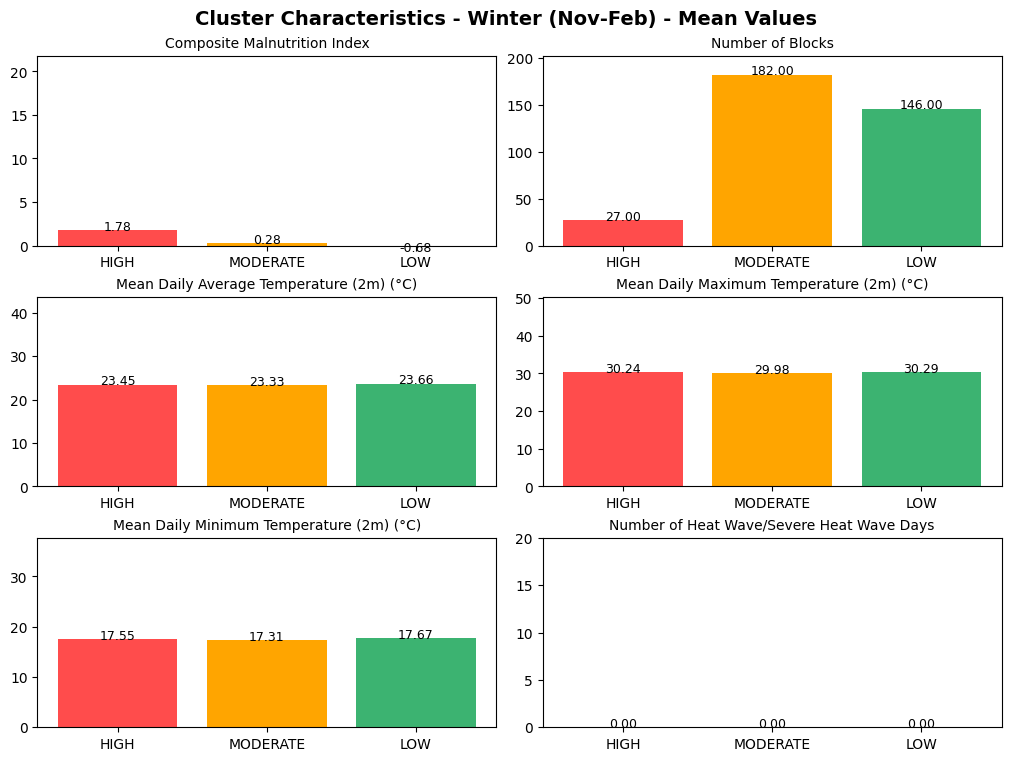

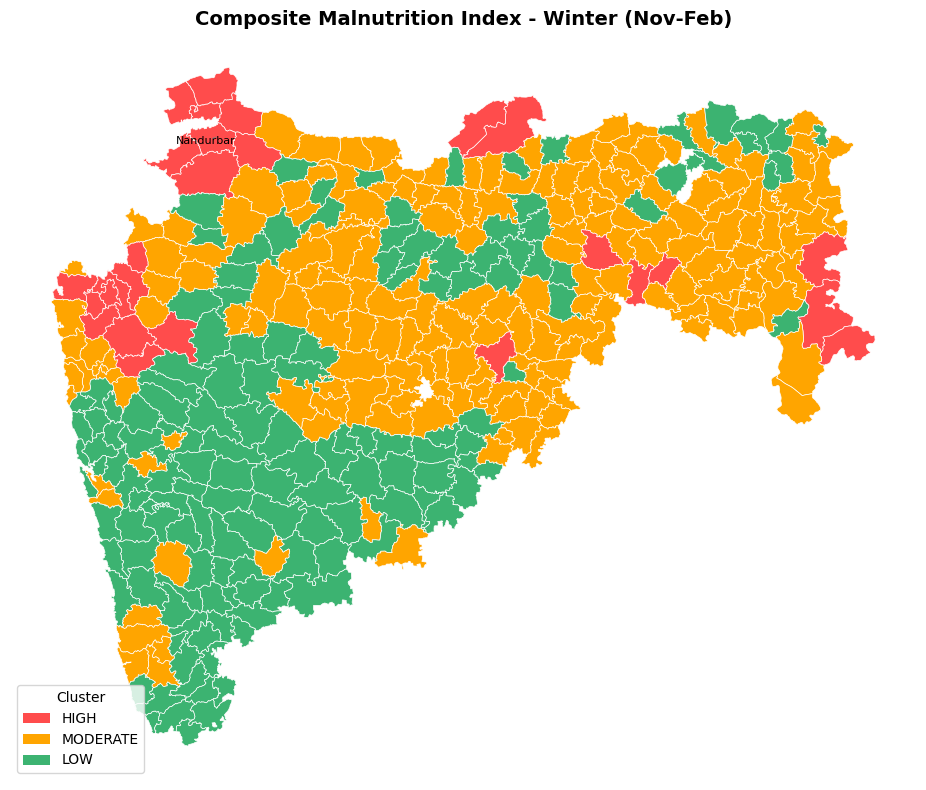

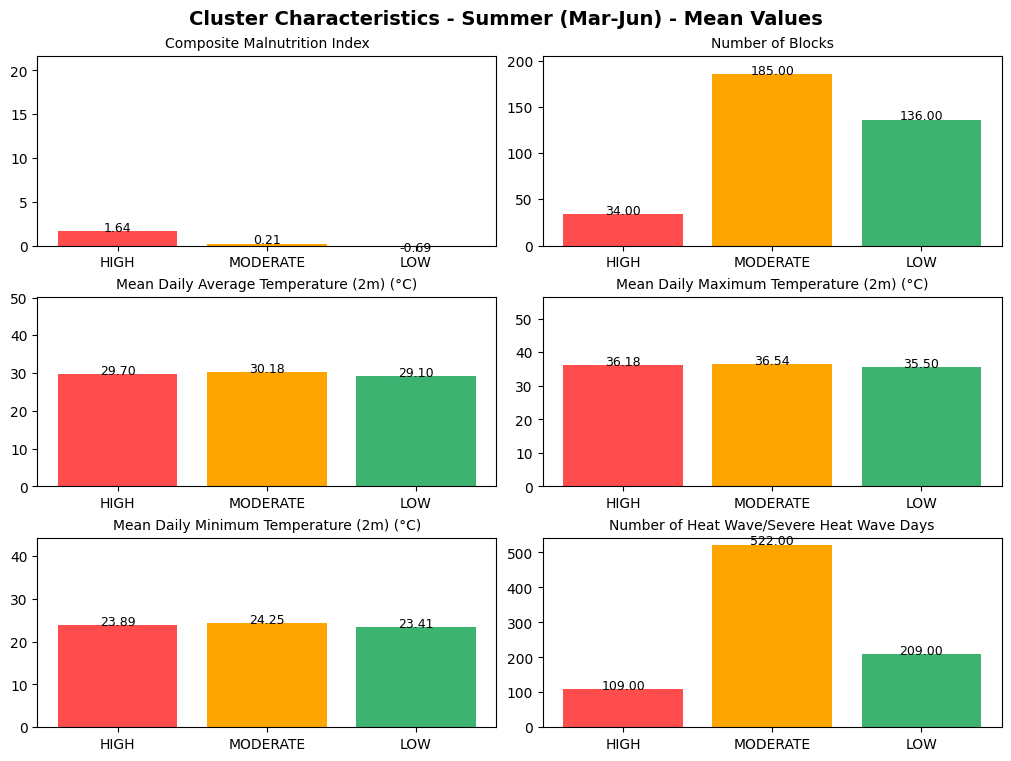

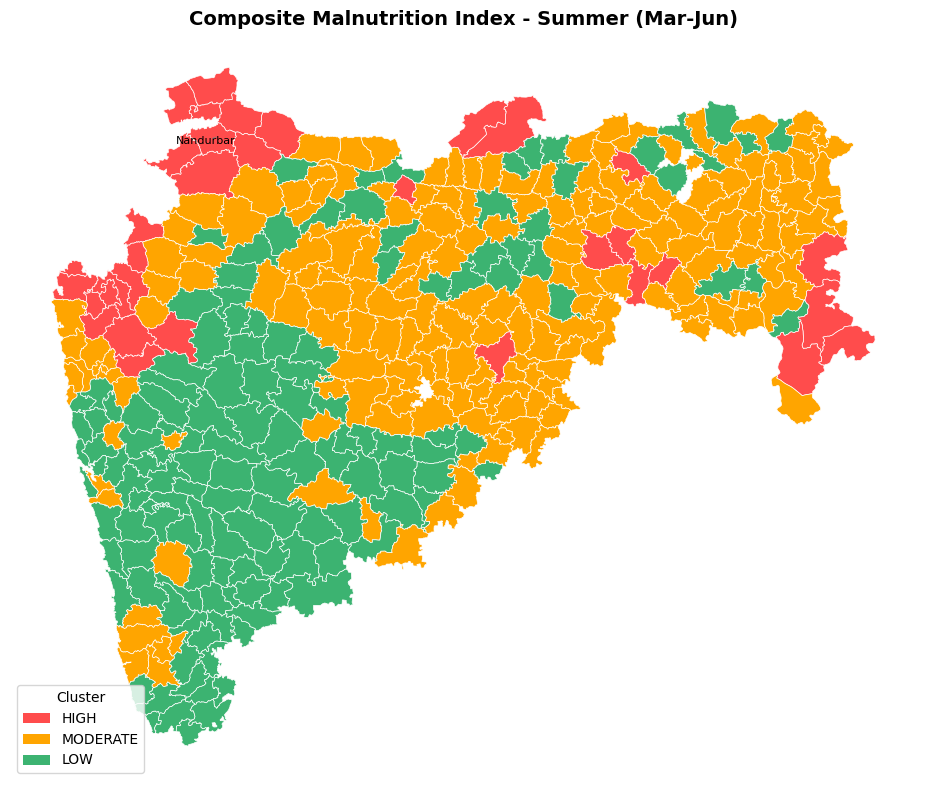

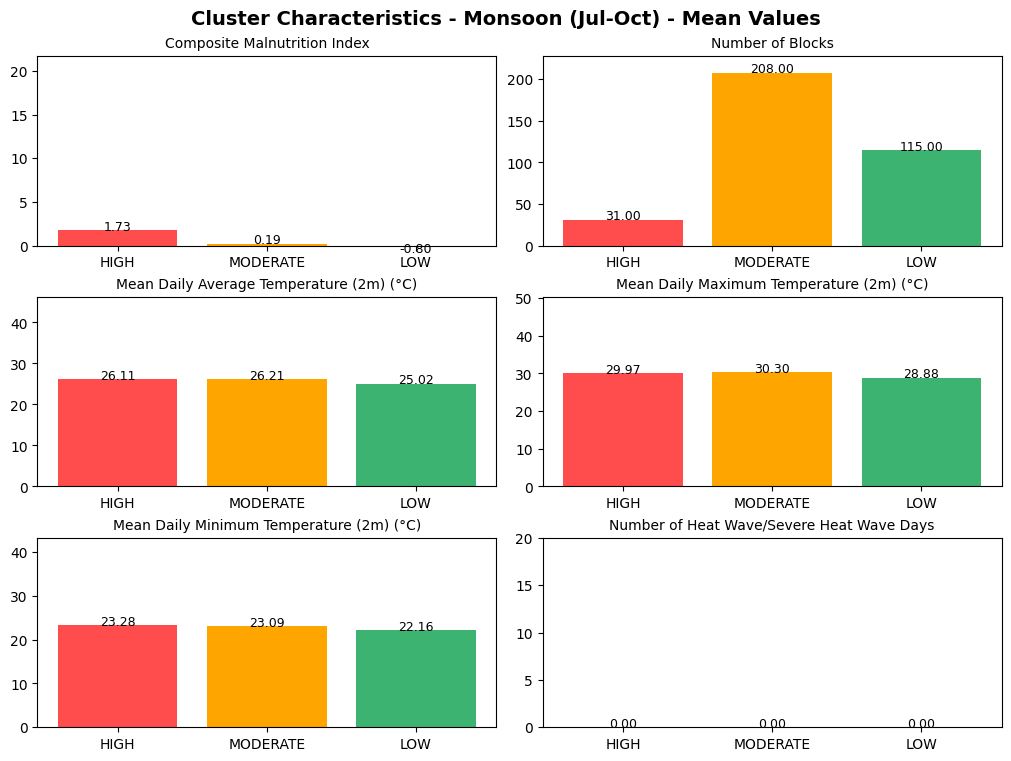

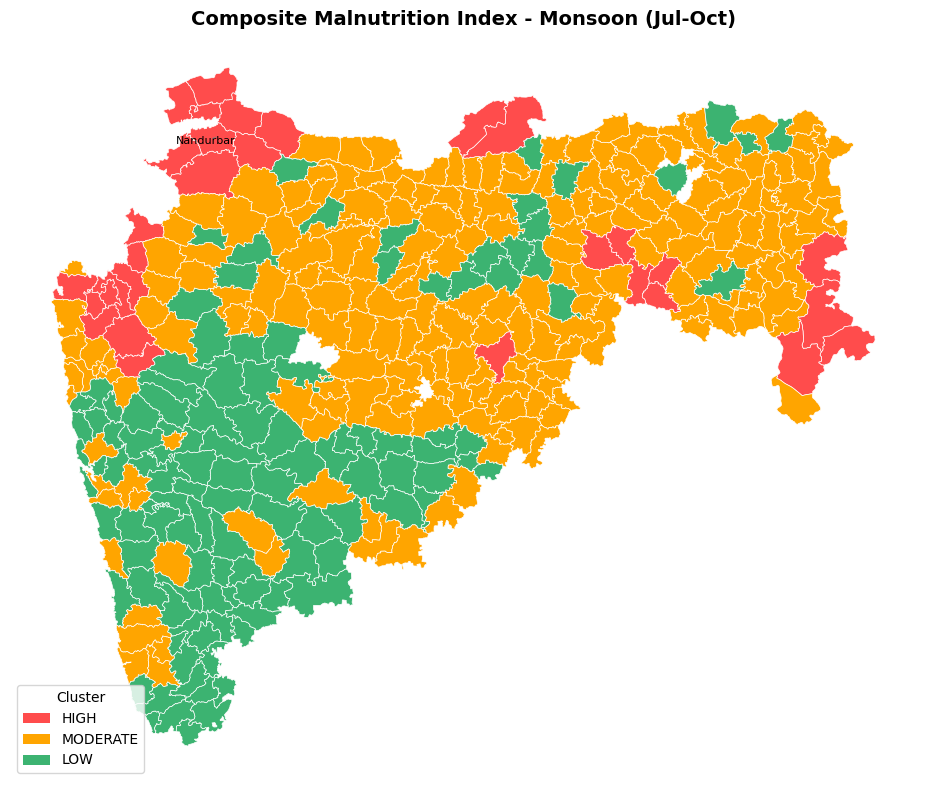

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.patches import Patch
from adjustText import adjust_text

# === Setup output directory ===
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# === Clean data ===
mal_gdf_clean = merged_gdf_season.dropna(subset=["geometry"] + malnutrition_vars).copy()
mal_gdf_clean = mal_gdf_clean.set_geometry("geometry")

# === Cluster Colors and Labels ===
cluster_colors = {
    'HIGH': '#FF4C4C',
    'MODERATE': '#FFA500',
    'LOW': '#3CB371'
}
cluster_order_sorted = ["HIGH", "MODERATE", "LOW"]
cluster_colors_list = [cluster_colors[c] for c in cluster_order_sorted]

# === Seasonal Loop ===
for s in list(month_block_df["season"].unique()):
    mal_gdf_clean_season = mal_gdf_clean[mal_gdf_clean["season"] == s].copy()

    # Standardize malnutrition indicators
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(mal_gdf_clean_season[malnutrition_vars])

    # Composite Index
    mal_gdf_clean_season["Composite Malnutrition Index"] = X_scaled.mean(axis=1)

    # KMeans clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    mal_gdf_clean_season["composite_cluster_raw"] = kmeans.fit_predict(mal_gdf_clean_season[["Composite Malnutrition Index"]])

    # Order cluster labels based on mean
    means = mal_gdf_clean_season.groupby("composite_cluster_raw")["Composite Malnutrition Index"].mean().sort_values(ascending=False)
    cluster_order = {old: new for new, old in enumerate(means.index)}
    label_map = {0: 'HIGH', 1: 'MODERATE', 2: 'LOW'}

    mal_gdf_clean_season["composite_cluster"] = mal_gdf_clean_season["composite_cluster_raw"].map(cluster_order)
    mal_gdf_clean_season["composite_cluster_label"] = mal_gdf_clean_season["composite_cluster"].map(label_map)
    mal_gdf_clean_season["color"] = mal_gdf_clean_season["composite_cluster_label"].map(cluster_colors)

    # Cluster summary
    mal_cluster_summary = mal_gdf_clean_season.groupby("composite_cluster_label").agg({
        "Composite Malnutrition Index": 'mean',
        'geometry': 'count',
        'Mean Daily Average Temperature (2m) (°C)': 'mean',
        'Mean Daily Maximum Temperature (2m) (°C)': 'mean',
        'Mean Daily Minimum Temperature (2m) (°C)': 'mean',

        'Number of Heat Wave/Severe Heat Wave Days': 'sum',
    }).rename(columns={"geometry": "Number of Blocks"}).reset_index()

    mal_cluster_summary["Cluster_Color"] = mal_cluster_summary["composite_cluster_label"].map(cluster_colors)
    mal_cluster_summary = mal_cluster_summary.rename(columns={"composite_cluster_label": "Cluster"})
    mal_cluster_summary = mal_cluster_summary.round(2)

    # === Bar Plot ===
    mal_cluster_melted = mal_cluster_summary.melt(
        id_vars=["Cluster", "Cluster_Color"], var_name='Variable', value_name='Mean'
    )
    mal_cluster_melted["Cluster"] = pd.Categorical(mal_cluster_melted["Cluster"], categories=cluster_order_sorted, ordered=True)

    variables = mal_cluster_melted['Variable'].unique()
    n_cols = 2
    n_rows = int(np.ceil(len(variables) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 2.5), constrained_layout=True)
    axes = axes.flatten()

    for i, var in enumerate(variables):
        ax = axes[i]
        subset = mal_cluster_melted[mal_cluster_melted["Variable"] == var]
        means = [subset[subset["Cluster"] == c]["Mean"].values[0] if not subset[subset["Cluster"] == c].empty else 0 for c in cluster_order_sorted]

        x_pos = np.arange(len(cluster_order_sorted))
        bars = ax.bar(x_pos, means, color=cluster_colors_list)

        for idx, bar in enumerate(bars):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                    f"{bar.get_height():.2f}", ha='center', fontsize=9)

        ax.set_xticks(x_pos)
        ax.set_xticklabels(cluster_order_sorted)
        ax.set_title(var, fontsize=10)
        ax.set_ylim(0, max(means) + 20)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"Cluster Characteristics - {s} - Mean Values", fontsize=14, fontweight='bold')
    plt.savefig(f"{output_dir}/composite_bar_{s}.png")
    plt.show()
    plt.close()

    # === Choropleth Map ===
    mal_gdf_clean_season = mal_gdf_clean_season.to_crs(epsg=3857)
    gdf_labels = mal_gdf_clean_season[mal_gdf_clean_season["sdtname"].str.lower() == "nandurbar"].copy()
    gdf_labels["coords"] = gdf_labels.geometry.centroid

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    mal_gdf_clean_season.plot(color=mal_gdf_clean_season["color"], edgecolor="white", linewidth=0.5, ax=ax)

    texts = []
    for _, row in gdf_labels.iterrows():
        x, y = row["coords"].x + 10000, row["coords"].y + 5000
        texts.append(ax.text(x, y, row["sdtname"], fontsize=8, ha="center", va="center"))

    adjust_text(
        texts, ax=ax,
        only_move={'points': 'y', 'text': 'y'},
        arrowprops=dict(arrowstyle="-", color="gray", lw=0.6, shrinkA=5, shrinkB=5),
        force_points=0.1, force_text=0.4,
        expand_text=(1.1, 1.3), expand_points=(1.1, 1.3)
    )

    legend_elements = [Patch(facecolor=clr, label=lbl) for lbl, clr in cluster_colors.items()]
    ax.legend(handles=legend_elements, title="Cluster", loc="lower left")
    ax.set_title(f"Composite Malnutrition Index - {s}", fontsize=14, fontweight="bold")
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/composite_cluster_{s}.png", dpi=300)
    plt.show()
    plt.close()


# 2a. Hotspot Identification - Gi & Moran's spatial autoregression (per malnutrition/climate indicator)

In [ ]:
merged_gdf.columns

Index(['OBJECTID', 'stcode11', 'dtcode11', 'sdtcode11', 'Shape_Leng',
       'Shape_Area', 'stname', 'dtname', 'sdtname', 'Subdt_LGD', 'Dist_LGD',
       'State_LGD', 'Updated sd', 'geometry', 'Stunting - Moderate (%)',
       'Stunting - Severe (%)', 'Underweight - Moderate (%)',
       'Underweight - Severe (%)', 'Wasting - SAM (%)', 'Wasting - MAM (%)',
       'Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)',
       'Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)',
       'Number of Heavy & Extremely Heavy Rainfall Days',
       'Number of Heat Wave/Severe Heat Wave Days', 'Number of Drought Months',
       'Stunting - Moderate', 'Stunting - Severe', 'Underweight - Moderate',
       'Underweight - Severe', 'Wasting - SAM', 'Wasting - MAM'],
      dtype='object')

In [ ]:
import geopandas as gpd
import libpysal
from esda import Moran_Local
from esda.getisord import G_Local
from splot.esda import lisa_cluster
import matplotlib.pyplot as plt
import os

# Set output directory (adjust path to your drive as needed)
output_dir = f"{main_path}/graphs/lisa_gistar_outputs"
os.makedirs(output_dir, exist_ok=True)

# Indicators to analyze
indicators = [
    'Stunting - Moderate (%)',
    'Stunting - Severe (%)',
    'Underweight - Moderate (%)',
    'Underweight - Severe (%)',
    'Wasting - SAM (%)',
    'Wasting - MAM (%)',
    'Mean Daily Average Temperature (2m) (°C)' ,
    'Mean Daily Maximum Temperature (2m) (°C)',
     'Number of Heat Wave/Severe Heat Wave Days'


]

# Ensure geometry is correctly set
merged_gdf = merged_gdf.set_geometry("geometry")

# Loop through each indicator
for indicator in indicators:
    if indicator not in merged_gdf.columns:
        print(f"Skipping {indicator}, not found in dataframe.")
        continue

    print(f"Running analysis for: {indicator}")

    # Drop NA for the current indicator
    gdf_clean = merged_gdf.dropna(subset=["geometry", indicator]).copy()

    # Generate Queen contiguity weights for clean data
    w_clean = libpysal.weights.Queen.from_dataframe(gdf_clean, use_index=False)
    w_clean.transform = 'r'

    # ------------------ Gi* Hotspot Analysis ------------------
    gi_star = G_Local(gdf_clean[indicator], w_clean)
    gdf_clean[f"{indicator}_gi_zscore"] = gi_star.Zs
    gdf_clean[f"{indicator}_gi_pvalue"] = gi_star.p_sim

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    gdf_clean.assign(significant=gdf_clean[f"{indicator}_gi_pvalue"] < 0.05).plot(
        column=f"{indicator}_gi_zscore",
        cmap='coolwarm',
        legend=True,
        ax=ax,
        edgecolor='k',
        linewidth=0.5
    )
    ax.set_title(f"Gi* Hotspot Analysis - {indicator}", fontsize=14, fontweight="bold")
    ax.axis("off")
    plt.tight_layout()
    # plt.savefig(f"{output_dir}/{indicator.replace(' ', '_').replace('(', '').replace(')', '')}_gi_hotspot.png", dpi=300)
    plt.show()

    # ------------------ Local Moran’s I (LISA) ------------------
    moran_local = Moran_Local(gdf_clean[indicator], w_clean)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    lisa_cluster(moran_local, gdf_clean, p=0.05, ax=ax)
    ax.set_title(f"LISA Cluster Map - {indicator}", fontsize=14, fontweight="bold")
    plt.tight_layout()
    # plt.savefig(f"{output_dir}/{indicator.replace(' ', '_').replace('(', '').replace(')', '')}_lisa_cluster.png", dpi=300)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# 2b. Multi-variate Hotspot Analysis - Gi & Moran's spatial autoregression (all malnutrition indicators combined - consolidated vulnerability score)

In [ ]:
merged_gdf.columns

Index(['OBJECTID', 'stcode11', 'dtcode11', 'sdtcode11', 'Shape_Leng',
       'Shape_Area', 'stname', 'dtname', 'sdtname', 'Subdt_LGD', 'Dist_LGD',
       'State_LGD', 'Updated sd', 'geometry', 'Stunting - Moderate (%)',
       'Stunting - Severe (%)', 'Underweight - Moderate (%)',
       'Underweight - Severe (%)', 'Wasting - SAM (%)', 'Wasting - MAM (%)',
       'Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)',
       'Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)',
       'Number of Heavy & Extremely Heavy Rainfall Days',
       'Number of Heat Wave/Severe Heat Wave Days', 'Number of Drought Months',
       'Stunting - Moderate', 'Stunting - Severe', 'Underweight - Moderate',
       'Underweight - Severe', 'Wasting - SAM', 'Wasting - MAM'],
      dtype='object')

In [ ]:
gdf_clean

OBJECTID stcode11 dtcode11 sdtcode11     Shape_Leng    Shape_Area  \
0        3969       27      497      3950  229977.366751  1.084474e+09   
1        3970       27      497      3951  206186.733326  1.498276e+09   
2        3971       27      497      3952  162472.061389  5.141909e+08   
3        3972       27      497      3953  195674.992974  1.405330e+09   
4        3973       27      497      3954  212746.249040  1.216660e+09   
..        ...      ...      ...       ...            ...           ...   
352      4322       27      732      4161  315955.959124  8.431235e+08   
353      4323       27      732      4162  197680.658831  9.029328e+08   
354      4324       27      732      4163  279359.485875  1.184824e+09   
355      4325       27      732      4164  141935.022250  6.303272e+08   
356      5950       27      526      4252  184316.344630  1.260304e+09   

          stname     dtname      sdtname  Subdt_LGD  ...  \
0    MAHARASHTRA  Nandurbar    Akkalkuwa     3950.0  ...   
1    MAHARASHTRA  Nandurbar       Akrani     3951.0  ...   
2    MAHARASHTRA  Nandurbar       Talode     3952.0  ...   
3    MAHARASHTRA  Nandurbar      Shahade     3953.0  ...   
4    MAHARASHTRA  Nandurbar    Nandurbar     3954.0  ...   
..           ...        ...          ...        ...  ...   
352  MAHARASHTRA    Palghar      Mokhada     4161.0  ...   
353  MAHARASHTRA    Palghar         Vada     4162.0  ...   
354  MAHARASHTRA    Palghar      Palghar     4163.0  ...   
355  MAHARASHTRA    Palghar        Vasai     4164.0  ...   
356  MAHARASHTRA    Solapur  Mangalvedhe     4252.0  ...   

     Underweight - Moderate  Underweight - Severe Wasting - SAM Wasting - MAM  \
0                  267528.0              100091.0       10582.0       44729.0   
1                  268570.0              126083.0       16904.0       49481.0   
2                  120477.0               41328.0        4148.0       20605.0   
3                  292330.0              106942.0       10297.0       48791.0   
4                  161589.0               55161.0        5374.0       29749.0   
..                      ...                   ...           ...           ...   
352                 57465.0               15808.0        1702.0        5421.0   
353                 97344.0               25267.0        2601.0        9729.0   
354                114486.0               16390.0        1988.0        8689.0   
355                 45478.0                8877.0        1583.0        5163.0   
356                 15655.0                3371.0        1249.0        3023.0   

     Stunting - Moderate (%)_z  Stunting - Severe (%)_z  \
0                     2.352880                 2.592665   
1                     1.775117                 3.297378   
2                     2.693207                 1.791305   
3                     1.972981                 2.089298   
4                     2.218333                 1.364450   
..                         ...                      ...   
352                   1.561423                 3.426240   
353                   1.387302                 2.878577   
354                   0.928257                 1.279884   
355                   0.841197                 1.324181   
356                  -0.417221                 0.055696   

     Underweight - Moderate (%)_z  Underweight - Severe (%)_z  \
0                        3.682888                    4.891467   
1                        3.836944                    6.731073   
2                        3.297748                    3.984803   
3                        2.970379                    4.024223   
4                        2.691152                    3.393501   
..                            ...                         ...   
352                      3.480689                    3.025580   
353                      2.460068                    2.040076   
354                      0.433269                   -0.377693   
355                      0.640282                    0.174189  

In [ ]:
indicators

['Stunting - Moderate (%)',
 'Stunting - Severe (%)',
 'Underweight - Moderate (%)',
 'Underweight - Severe (%)',
 'Wasting - SAM (%)',
 'Wasting - MAM (%)',
 'Mean Daily Average Temperature (2m) (°C)',
 'Mean Daily Maximum Temperature (2m) (°C)',
 'Number of Heat Wave/Severe Heat Wave Days']

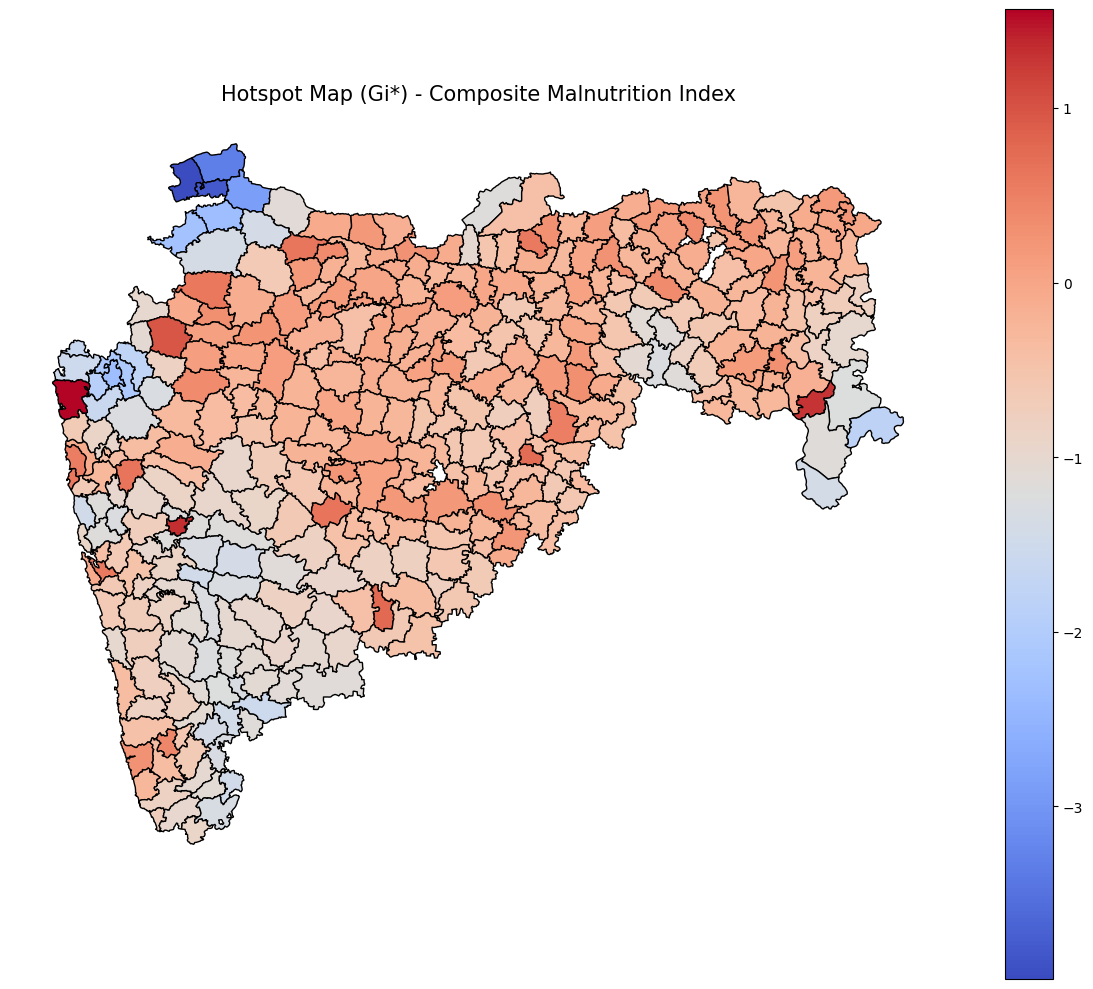

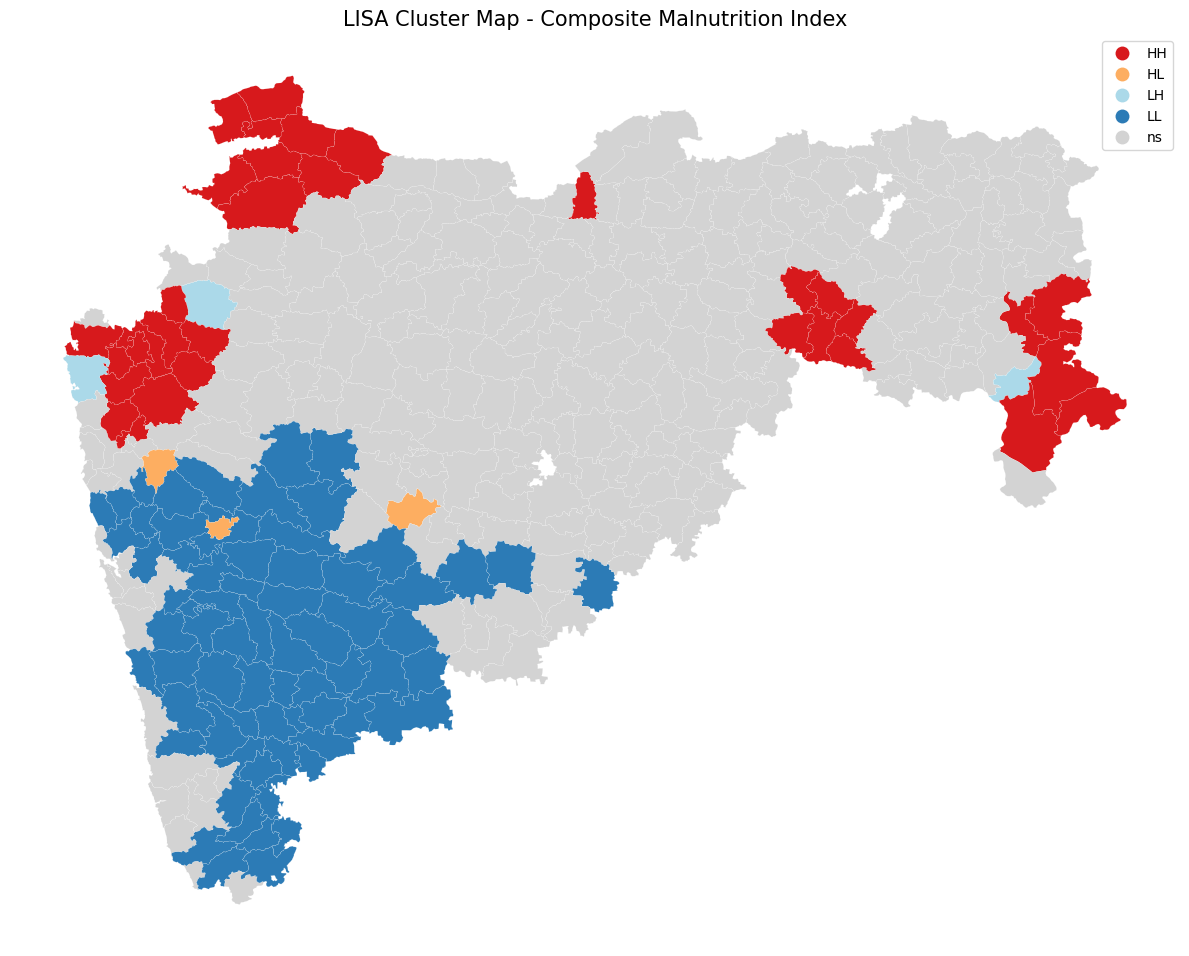

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import libpysal
from esda.getisord import G_Local
from esda import Moran_Local
from splot.esda import lisa_cluster

selected_heat_vars=['Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)']

# Ensure geometry is set
merged_gdf = merged_gdf.set_geometry("geometry")

# Drop NAs across all indicators and geometry
gdf_clean = merged_gdf.dropna(subset=["geometry"] + malnutrition_vars).copy()

# Standardize each indicator to z-score
for indicator in malnutrition_vars:
    gdf_clean[f"{indicator}_z"] = (gdf_clean[indicator] - gdf_clean[indicator].mean()) / gdf_clean[indicator].std()

# Create consolidated vulnerability score (mean of z-scores)
z_columns = [f"{indicator}_z" for indicator in ['Stunting - Moderate (%)',
 'Stunting - Severe (%)',
 'Underweight - Moderate (%)',
 'Underweight - Severe (%)',
 'Wasting - SAM (%)',
 'Wasting - MAM (%)']]
gdf_clean["vulnerability_score"] = gdf_clean[z_columns].mean(axis=1)

# Spatial weights
w = libpysal.weights.Queen.from_dataframe(gdf_clean, use_index=False)

w.transform = "r"

# Run Getis-Ord Gi* on the vulnerability score
gi_star = G_Local(gdf_clean["vulnerability_score"], w)
gdf_clean["vulnerability_gi_zscore"] = gi_star.Zs
gdf_clean["vulnerability_gi_pvalue"] = gi_star.p_sim

# Plot Gi* Hotspots for Vulnerability Score
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_clean.assign(significant=gdf_clean["vulnerability_gi_pvalue"] < 0.05).plot(
    column="vulnerability_gi_zscore", cmap='coolwarm', legend=True, ax=ax, edgecolor='k'
)
ax.set_title("Hotspot Map (Gi*) - Composite Malnutrition Index", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()

# Run Local Moran's I (LISA)
moran_local = Moran_Local(gdf_clean["vulnerability_score"], w)

# Plot LISA cluster map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
lisa_cluster(moran_local, gdf_clean, p=0.05, ax=ax)
ax.set_title("LISA Cluster Map - Composite Malnutrition Index", fontsize=15)
plt.tight_layout()
plt.show()


# Composite Temperature Index

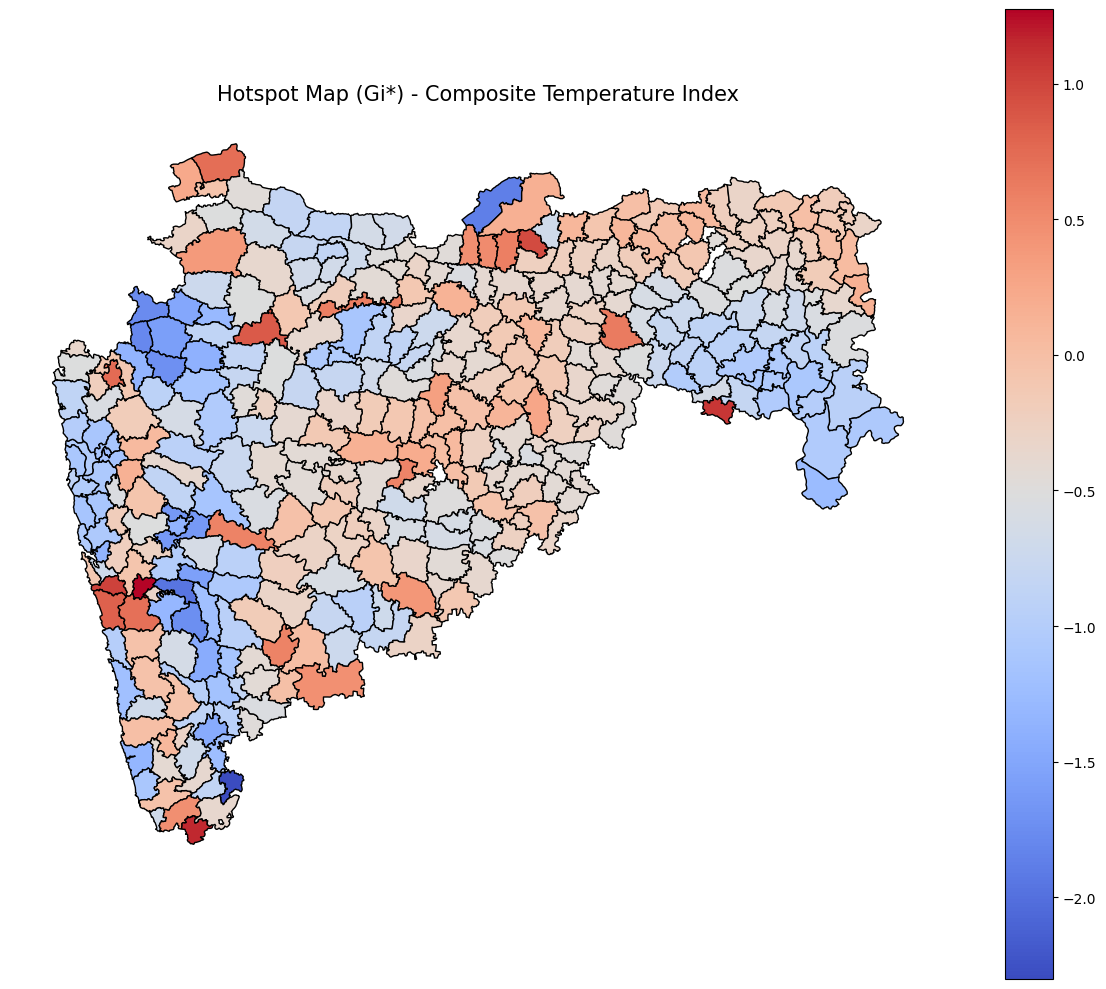

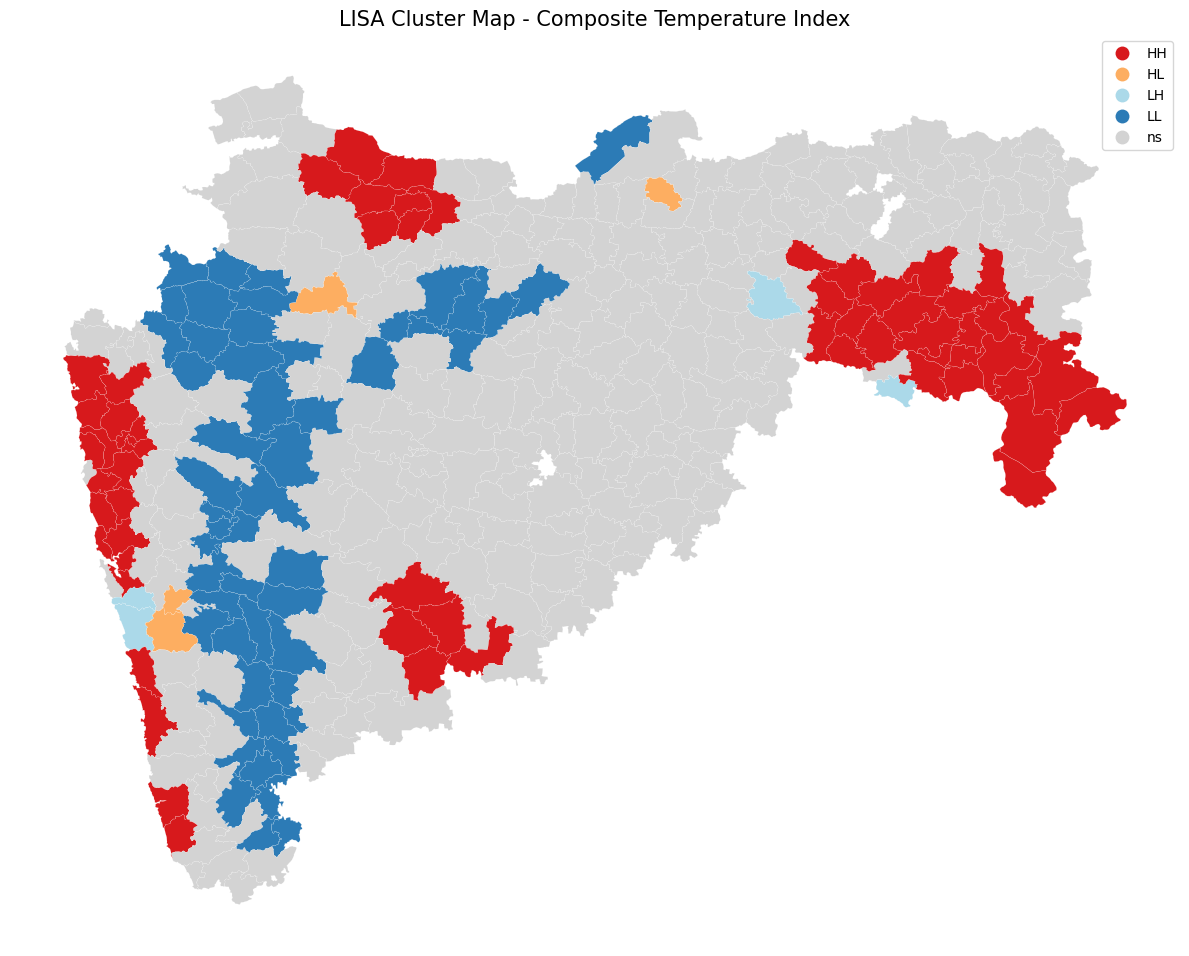

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import libpysal
from esda.getisord import G_Local
from esda import Moran_Local
from splot.esda import lisa_cluster

selected_heat_vars=['Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)']

# Ensure geometry is set
merged_gdf = merged_gdf.set_geometry("geometry")

# Drop NAs across all indicators and geometry
gdf_clean = merged_gdf.dropna(subset=["geometry"] + malnutrition_vars).copy()

# Standardize each indicator to z-score
for indicator in selected_heat_vars:
    gdf_clean[f"{indicator}_z"] = (gdf_clean[indicator] - gdf_clean[indicator].mean()) / gdf_clean[indicator].std()

# Create consolidated vulnerability score (mean of z-scores)
z_columns = [f"{indicator}_z" for indicator in selected_heat_vars]
gdf_clean["vulnerability_score"] = gdf_clean[z_columns].mean(axis=1)

# Spatial weights
w = libpysal.weights.Queen.from_dataframe(gdf_clean, use_index=False)

w.transform = "r"

# Run Getis-Ord Gi* on the vulnerability score
gi_star = G_Local(gdf_clean["vulnerability_score"], w)
gdf_clean["vulnerability_gi_zscore"] = gi_star.Zs
gdf_clean["vulnerability_gi_pvalue"] = gi_star.p_sim

# Plot Gi* Hotspots for Vulnerability Score
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_clean.assign(significant=gdf_clean["vulnerability_gi_pvalue"] < 0.05).plot(
    column="vulnerability_gi_zscore", cmap='coolwarm', legend=True, ax=ax, edgecolor='k'
)
ax.set_title("Hotspot Map (Gi*) - Composite Temperature Index", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()

# Run Local Moran's I (LISA)
moran_local = Moran_Local(gdf_clean["vulnerability_score"], w)

# Plot LISA cluster map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
lisa_cluster(moran_local, gdf_clean, p=0.05, ax=ax)
ax.set_title("LISA Cluster Map - Composite Temperature Index", fontsize=15)
plt.tight_layout()
plt.show()


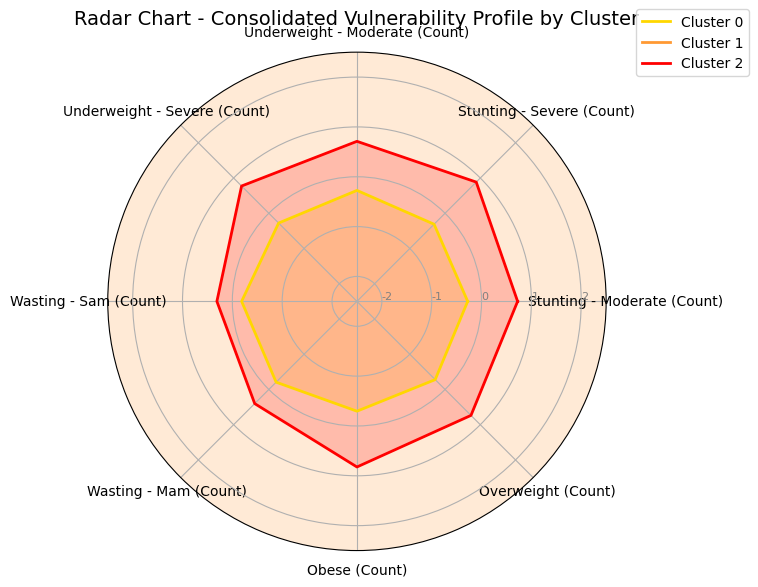

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from math import pi

# Standardize indicators
scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(gdf_clean[indicators])

# Run KMeans on all indicators
kmeans = KMeans(n_clusters=3, random_state=42)
gdf_clean["vulnerability_cluster"] = kmeans.fit_predict(X_scaled_all)

# Prepare data for radar chart
cluster_radar = pd.DataFrame(X_scaled_all, columns=indicators)
cluster_radar["cluster"] = gdf_clean["vulnerability_cluster"]
radar_means = cluster_radar.groupby("cluster").mean()

# Setup radar chart
categories = indicators
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # close the loop

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Colors for clusters
radar_colors = {
    0: '#FFD700',  # Gold
    1: '#FF9933',  # Saffron
    2: '#FF0000',  # Red
}

# Plot each cluster
for cluster_id in sorted(radar_means.index):
    values = radar_means.loc[cluster_id].tolist()
    values += values[:1]  # close loop

    ax.plot(angles, values, linewidth=2, linestyle='solid',
            label=f"Cluster {cluster_id}", color=radar_colors[cluster_id])
    ax.fill(angles, values, alpha=0.2, color=radar_colors[cluster_id])

# Format chart
plt.xticks(angles[:-1], [i.replace("_", " ").title() for i in categories], color='black', size=10)
ax.set_rlabel_position(0)
plt.yticks([-2, -1, 0, 1, 2], ["-2", "-1", "0", "1", "2"], color="grey", size=8)
plt.ylim(-2.5, 2.5)
plt.title("Radar Chart - Consolidated Vulnerability Profile by Cluster", size=14, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


# 2c. LISA Gi* on Climate Composite Index

In [ ]:
!pip install libpysal esda splot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.2/388.2 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 19.5 MB/s eta 0:00:00


In [ ]:
merged_gdf.columns

Index(['OBJECTID', 'stcode11', 'dtcode11', 'sdtcode11', 'Shape_Leng',
       'Shape_Area', 'stname', 'dtname', 'sdtname', 'Subdt_LGD', 'Dist_LGD',
       'State_LGD', 'Updated sd', 'geometry', 'Stunting - Moderate (%)',
       'Stunting - Severe (%)', 'Underweight - Moderate (%)',
       'Underweight - Severe (%)', 'Wasting - SAM (%)', 'Wasting - MAM (%)',
       'Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)',
       'Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)',
       'Number of Heavy & Extremely Heavy Rainfall Days',
       'Number of Heat Wave/Severe Heat Wave Days', 'Number of Drought Months',
       'Stunting - Moderate', 'Stunting - Severe', 'Underweight - Moderate',
       'Underweight - Severe', 'Wasting - SAM', 'Wasting - MAM'],
      dtype='object')

## Percentile-based clusters

<ipython-input-228-a9a7f621d9b4>:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mal_cluster_summary = mal_gdf_clean.groupby("composite_cluster_label").agg({


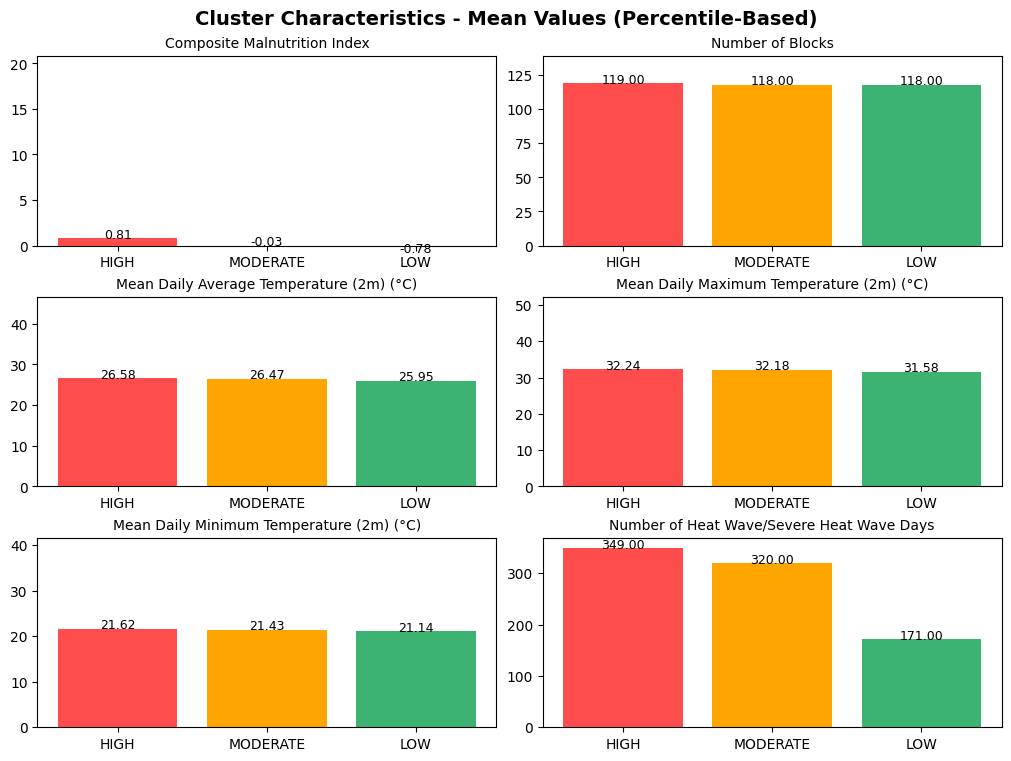

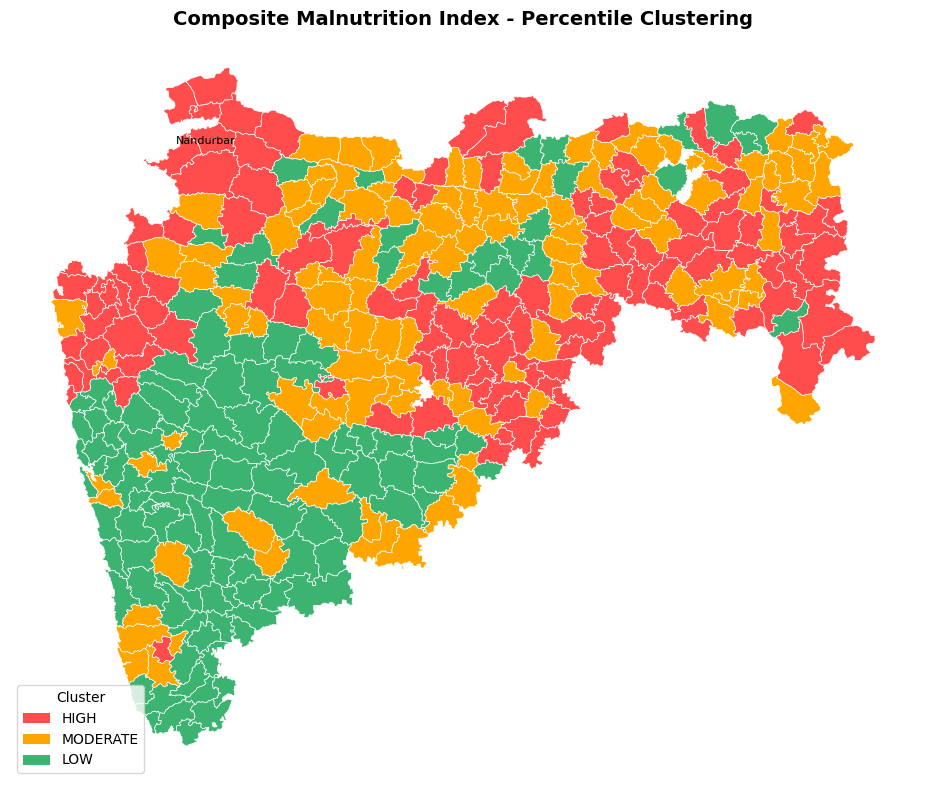

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler
import os

# Clean and standardize data
mal_gdf_clean = merged_gdf.dropna(subset=["geometry"] + malnutrition_vars).copy()
mal_gdf_clean = mal_gdf_clean.set_geometry("geometry")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(mal_gdf_clean[malnutrition_vars])
mal_gdf_clean["Composite Malnutrition Index"] = X_scaled.mean(axis=1)

# Percentile-based clustering
mal_gdf_clean["composite_cluster_label"] = pd.qcut(
    mal_gdf_clean["Composite Malnutrition Index"],
    q=3,
    labels=["LOW", "MODERATE", "HIGH"]
)

# Color mapping
cluster_colors = {'HIGH': '#FF4C4C', 'MODERATE': '#FFA500', 'LOW': '#3CB371'}
mal_gdf_clean["color"] = mal_gdf_clean["composite_cluster_label"].map(cluster_colors)

# Cluster summary
mal_cluster_summary = mal_gdf_clean.groupby("composite_cluster_label").agg({
    "Composite Malnutrition Index": 'mean',
    'geometry': 'count',
    'Mean Daily Average Temperature (2m) (°C)': 'mean',
       'Mean Daily Maximum Temperature (2m) (°C)': 'mean',
       'Mean Daily Minimum Temperature (2m) (°C)': 'mean',
    'Number of Heat Wave/Severe Heat Wave Days': 'sum'

}).rename(columns={"geometry": "Number of Blocks"}).reset_index()

mal_cluster_summary["Cluster_Color"] = mal_cluster_summary["composite_cluster_label"].map(cluster_colors)
mal_cluster_summary = mal_cluster_summary.rename(columns={"composite_cluster_label": "Cluster"})
mal_cluster_summary = mal_cluster_summary.round(2)

# Melt for bar plotting
mal_cluster_melted = mal_cluster_summary.melt(id_vars=["Cluster", "Cluster_Color"], var_name='Variable', value_name='Mean')
cluster_order_sorted = ["HIGH", "MODERATE", "LOW"]
mal_cluster_melted["Cluster"] = pd.Categorical(mal_cluster_melted["Cluster"], categories=cluster_order_sorted, ordered=True)

# Plot: Cluster characteristics bar plot
variables = mal_cluster_melted['Variable'].unique()
cluster_colors_list = [cluster_colors[c] for c in cluster_order_sorted]

n_cols = 2
n_rows = int(np.ceil(len(variables) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 2.5), constrained_layout=True)
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]
    subset = mal_cluster_melted[mal_cluster_melted["Variable"] == var]
    means = [subset[subset["Cluster"] == c]["Mean"].values[0] for c in cluster_order_sorted]

    bars = ax.bar(np.arange(len(cluster_order_sorted)), means, color=cluster_colors_list)
    for idx, bar in enumerate(bars):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f"{bar.get_height():.2f}", ha='center', fontsize=9)

    ax.set_xticks(np.arange(len(cluster_order_sorted)))
    ax.set_xticklabels(cluster_order_sorted)
    ax.set_title(var, fontsize=10)
    ax.set_ylim(0, max(means) + 20)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Cluster Characteristics - Mean Values (Percentile-Based)", fontsize=14, fontweight='bold')
plt.savefig(f"{output_dir}/composite_bar_vertical_percentile.png")

# Choropleth map
mal_gdf_clean = mal_gdf_clean.to_crs(epsg=3857)
gdf_labels = mal_gdf_clean[mal_gdf_clean["sdtname"].str.lower() == "nandurbar"].copy()
gdf_labels["coords"] = gdf_labels["geometry"].centroid

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mal_gdf_clean.plot(color=mal_gdf_clean["color"], edgecolor="white", linewidth=0.5, ax=ax)

texts = []
for _, row in gdf_labels.iterrows():
    x, y = row["coords"].x + 10000, row["coords"].y + 5000
    text = ax.text(x, y, row["sdtname"], fontsize=8, ha="center", va="center")
    texts.append(text)

adjust_text(texts, ax=ax, only_move={'points': 'y', 'text': 'y'},
            arrowprops=dict(arrowstyle="-", color="gray", lw=0.6),
            force_points=0.1, force_text=0.4)

legend_elements = [Patch(facecolor=clr, label=lbl) for lbl, clr in cluster_colors.items()]
ax.legend(handles=legend_elements, title="Cluster", loc="lower left")

ax.set_title("Composite Malnutrition Index - Percentile Clustering", fontsize=14, fontweight="bold")
ax.axis("off")
plt.tight_layout()
plt.savefig(f"{output_dir}/composite_cluster_map_percentile.png", dpi=300)
plt.show()


In [ ]:
merged_gdf.columns

Index(['OBJECTID', 'stcode11', 'dtcode11', 'sdtcode11', 'Shape_Leng',
       'Shape_Area', 'stname', 'dtname', 'sdtname', 'Subdt_LGD', 'Dist_LGD',
       'State_LGD', 'Updated sd', 'geometry', 'Stunting - Moderate (%)',
       'Stunting - Severe (%)', 'Underweight - Moderate (%)',
       'Underweight - Severe (%)', 'Wasting - SAM (%)', 'Wasting - MAM (%)',
       'Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)',
       'Sum Daily Precipitation (Rain, Showers, Snowfall) (mm)',
       'Number of Heavy & Extremely Heavy Rainfall Days',
       'Number of Heat Wave/Severe Heat Wave Days', 'Number of Drought Months',
       'Stunting - Moderate', 'Stunting - Severe', 'Underweight - Moderate',
       'Underweight - Severe', 'Wasting - SAM', 'Wasting - MAM'],
      dtype='object')

<ipython-input-229-171eacc45d50>:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  climate_cluster_summary = climate_gdf_clean.groupby("climate_composite_cluster_label").agg({


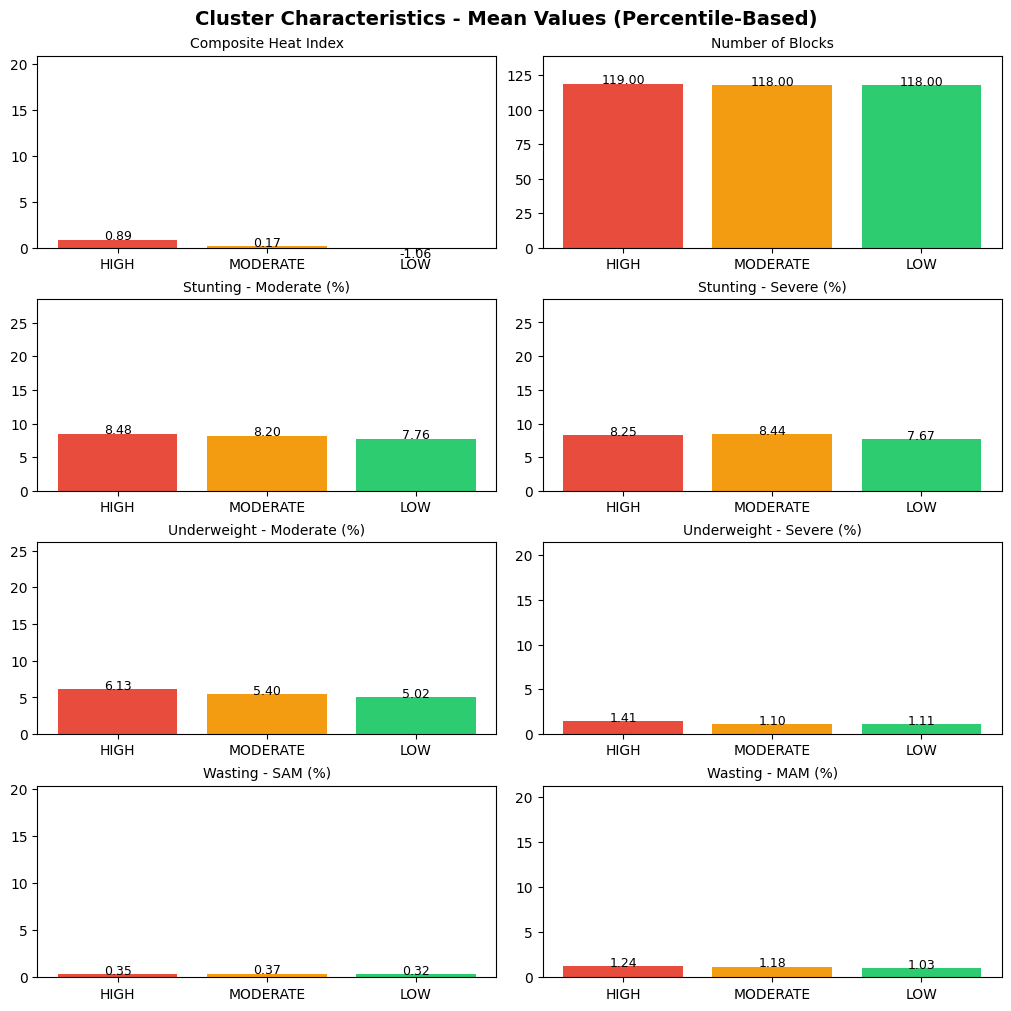

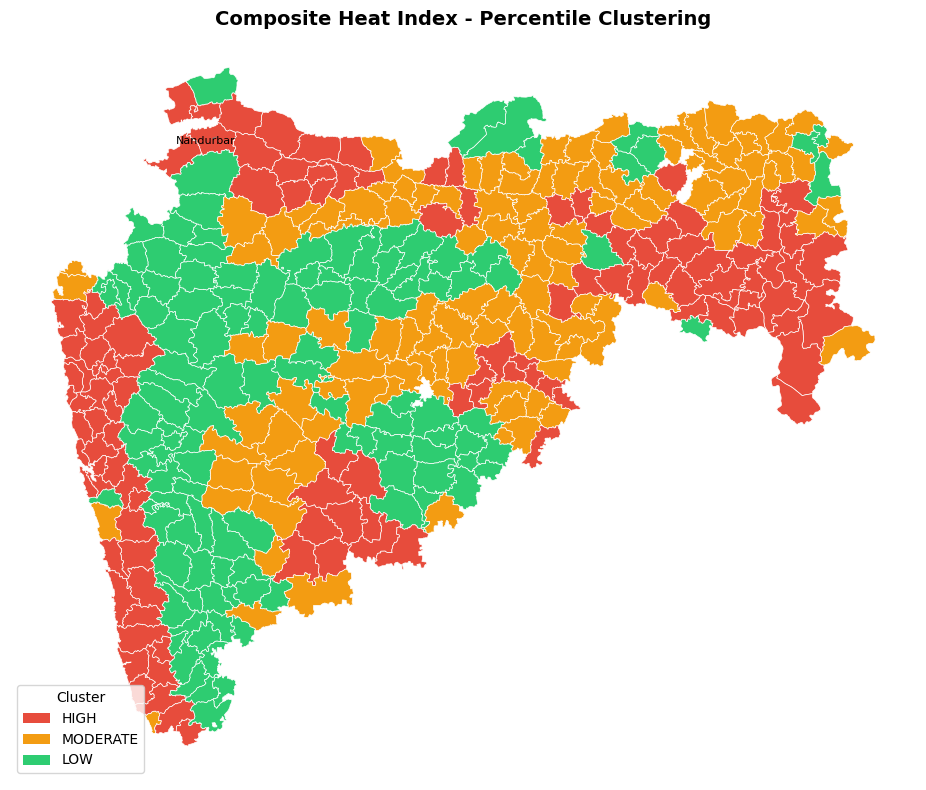

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.patches import Patch
from adjustText import adjust_text

selected_heat_vars = [
   'Mean Daily Average Temperature (2m) (°C)',
       'Mean Daily Maximum Temperature (2m) (°C)',
       'Mean Daily Minimum Temperature (2m) (°C)'
]

# Setup
output_dir = f"{main_path}/graphs/cluster_outputs"
os.makedirs(output_dir, exist_ok=True)

# Clean and prepare geodataframe
climate_gdf_clean = merged_gdf.dropna(subset=["geometry"] + selected_heat_vars).copy()
climate_gdf_clean = climate_gdf_clean.set_geometry("geometry")

# Standardize and compute index
scaler = StandardScaler()
X_scaled = scaler.fit_transform(climate_gdf_clean[selected_heat_vars])
climate_gdf_clean["Composite Heat Index"] = X_scaled.mean(axis=1)

# Use percentile-based clustering
climate_gdf_clean["climate_composite_cluster_label"] = pd.qcut(
    climate_gdf_clean["Composite Heat Index"],
    q=3,
    labels=["LOW", "MODERATE", "HIGH"]
)

# Color mapping
climate_cluster_colors = {
    'HIGH': '#E74C3C',
    'MODERATE': '#F39C12',
    'LOW': '#2ECC71'
}
climate_gdf_clean["color"] = climate_gdf_clean["climate_composite_cluster_label"].map(climate_cluster_colors)

# Cluster summary
climate_cluster_summary = climate_gdf_clean.groupby("climate_composite_cluster_label").agg({
    "Composite Heat Index": 'mean',
    'geometry': 'count',
    'Stunting - Moderate (%)': 'mean',
    'Stunting - Severe (%)': 'mean',
    'Underweight - Moderate (%)': 'mean',
    'Underweight - Severe (%)': 'mean',
    'Wasting - SAM (%)': 'mean',
    'Wasting - MAM (%)': 'mean',
}).rename(columns={"geometry": "Number of Blocks"}).reset_index()

climate_cluster_summary["Cluster_Color"] = climate_cluster_summary["climate_composite_cluster_label"].map(climate_cluster_colors)
climate_cluster_summary = climate_cluster_summary.rename(columns={"climate_composite_cluster_label": "Cluster"})

# Melt for plotting
climate_melted = climate_cluster_summary.melt(id_vars=['Cluster', 'Cluster_Color'], var_name='Variable', value_name='Mean')
cluster_order_sorted = ["HIGH", "MODERATE", "LOW"]
climate_melted["Cluster"] = pd.Categorical(climate_melted["Cluster"], categories=cluster_order_sorted, ordered=True)

# Grid layout
variables = climate_melted['Variable'].unique()
cluster_colors_list = [climate_cluster_colors[c] for c in cluster_order_sorted]

n_cols = 2
n_rows = int(np.ceil(len(variables) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 2.5), constrained_layout=True)
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]
    subset = climate_melted[climate_melted["Variable"] == var]
    means = [subset[subset["Cluster"] == c]["Mean"].values[0] for c in cluster_order_sorted]

    bars = ax.bar(np.arange(len(cluster_order_sorted)), means, color=cluster_colors_list)
    for idx, bar in enumerate(bars):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f"{bar.get_height():.2f}", ha='center', fontsize=9)

    ax.set_xticks(np.arange(len(cluster_order_sorted)))
    ax.set_xticklabels(cluster_order_sorted)
    ax.set_title(var, fontsize=10)
    ax.set_ylim(0, max(means) + 20)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Cluster Characteristics - Mean Values (Percentile-Based)", fontsize=14, fontweight='bold')
plt.savefig(f"{output_dir}/heat_bar_vertical_percentile.png")

# Choropleth map
climate_gdf_clean = climate_gdf_clean.to_crs(epsg=3857)
gdf_labels = climate_gdf_clean[climate_gdf_clean["sdtname"].str.lower() == "nandurbar"].copy()
gdf_labels["coords"] = gdf_labels.geometry.centroid

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
climate_gdf_clean.plot(color=climate_gdf_clean["color"], edgecolor="white", linewidth=0.5, ax=ax)

texts = []
for _, row in gdf_labels.iterrows():
    x, y = row["coords"].x + 10000, row["coords"].y + 5000
    text = ax.text(x, y, row["sdtname"], fontsize=8, ha="center", va="center")
    texts.append(text)

adjust_text(
    texts, ax=ax,
    only_move={'points': 'y', 'text': 'y'},
    arrowprops=dict(arrowstyle="-", color="gray", lw=0.6, shrinkA=5, shrinkB=5),
    force_points=0.1, force_text=0.4,
    expand_text=(1.1, 1.3), expand_points=(1.1, 1.3)
)

legend_elements = [Patch(facecolor=clr, label=lbl) for lbl, clr in climate_cluster_colors.items()]
ax.legend(handles=legend_elements, title="Cluster", loc="lower left")

ax.set_title("Composite Heat Index - Percentile Clustering", fontsize=14, fontweight="bold")
ax.axis("off")
plt.tight_layout()
plt.savefig(f"{output_dir}/heat_cluster_map_percentile.png", dpi=300)
plt.show()


In [ ]:
merged_blocks=climate_gdf_clean[["sdtcode11", "sdtname", "geometry", "climate_composite_cluster_label", "color"]].merge(mal_gdf_clean[["sdtcode11", "composite_cluster_label"]], on="sdtcode11")
merged_blocks.loc[(merged_blocks["climate_composite_cluster_label"]=="HIGH") & (merged_blocks["composite_cluster_label"]=="HIGH"), "new_color"]="#E74C3C"
merged_blocks["new_color"]=merged_blocks["new_color"].fillna('#FFFFFF')

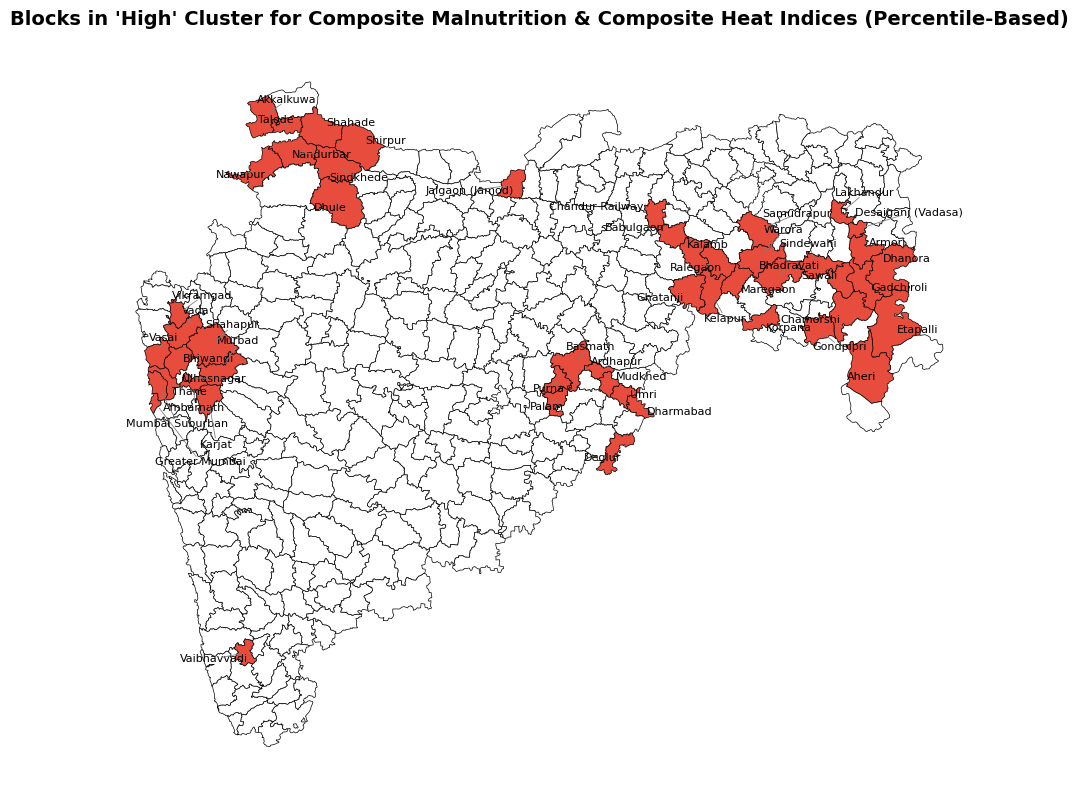

In [ ]:
# Choropleth Map
merged_blocks = merged_blocks.to_crs(epsg=3857)
gdf_labels = merged_blocks[
    (merged_blocks["climate_composite_cluster_label"].str.lower() == "high") & (merged_blocks["composite_cluster_label"].str.lower() == "high")
].copy()

gdf_labels = gdf_labels.copy()
gdf_labels["coords"] = gdf_labels.geometry.centroid

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged_blocks.plot(color=merged_blocks["new_color"], edgecolor="black", linewidth=0.5, ax=ax)

# Add non-overlapping labels
texts = []
for _, row in gdf_labels.iterrows():
    x, y = row["coords"].x, row["coords"].y
    text = ax.text(x, y, row["sdtname"], fontsize=8, ha="center", va="center")
    texts.append(text)

adjust_text(
    texts, ax=ax,
    only_move={'points': 'y', 'text': 'y'},
    arrowprops=dict(arrowstyle="-", color="gray", lw=0.6, shrinkA=5, shrinkB=5),
    force_points=0.1, force_text=0.4,
    expand_text=(1.1, 1.3), expand_points=(1.1, 1.3)
)

# legend_elements = [Patch(facecolor=clr, label=lbl) for lbl, clr in climate_cluster_colors.items()]
# ax.legend(handles=legend_elements, title="Cluster", loc="lower left")

ax.set_title("Blocks in 'High' Cluster for Composite Malnutrition & Composite Heat Indices (Percentile-Based)", fontsize=14, fontweight="bold")
ax.axis("off")
plt.tight_layout()
plt.savefig(f"{output_dir}/high_heat_malnutrition_percentile.png", dpi=300)
plt.show()

In [ ]:
len(merged_blocks.loc[(merged_blocks["climate_composite_cluster_label"]=="HIGH") & (merged_blocks["composite_cluster_label"]=="HIGH")])

52

## Composite Index of Anthropometric Failure (CIAF)

| Category | Description                                                                             |
| -------- | --------------------------------------------------------------------------------------- |
| **A**    | No failure — child is not wasted, stunted, or underweight (or data is missing/invalid). |
| **B**    | Only **wasted** — acute undernutrition without stunting or underweight.                 |
| **C**    | **Wasted and underweight**, but not stunted — acute and weight-for-age failure.         |
| **D**    | **Wasted, stunted, and underweight** — all three failures present.                      |
| **E**    | **Stunted and underweight**, but not wasted — chronic and weight-for-age failure.       |
| **F**    | Only **stunted** — chronic undernutrition without wasting or underweight.               |
| **G**    | Only **underweight** — weight-for-age failure without wasting or stunting.              |
| **Y**    | **Wasted and stunted**, but not underweight — acute and chronic failure.                |




In [13]:
ciaf_block=pd.read_csv(f'{main_path}/2_Data/POSHAN/ciaf_block.csv')

In [15]:
ciaf_block.columns

Index(['District ID', 'sdtcode11', 'ciaf_a_count', 'ciaf_b_count',
       'ciaf_c_count', 'ciaf_d_count', 'ciaf_e_count', 'ciaf_f_count',
       'ciaf_g_count', 'ciaf_y_count', 'measured_children', 'ciaf_a_percent',
       'ciaf_b_percent', 'ciaf_c_percent', 'ciaf_d_percent', 'ciaf_e_percent',
       'ciaf_f_percent', 'ciaf_g_percent', 'ciaf_y_percent'],
      dtype='object')

In [ ]:
# The End!